In [1]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# Data

In [3]:
START = '2007-01-01'
END = '2022-03-31'

In [4]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
stk_info = stk_info[cond1 & cond2].copy()
stk_id = stk_info['secID']

In [5]:
stk_info

,secID,ticker,secShortName,cnSpell,exchangeCD,assetClass,listStatusCD,listDate,transCurrCD,ISIN,partyID,delistDate
0,000001.XSHE,000001,平安银行,PAYH,XSHE,E,L,1991-04-03,CNY,CNE000000040,2.0,NaN
1,000002.XSHE,000002,万科A,WKA,XSHE,E,L,1991-01-29,CNY,CNE0000000T2,3.0,NaN
2,000003.XSHE,000003,PT金田A,PTJTA,XSHE,E,DE,1991-07-03,CNY,CNE1000031Y5,4.0,2002-06-14
3,000004.XSHE,000004,国华网安,GHWA,XSHE,E,L,1991-01-14,CNY,CNE0000000Y2,5.0,NaN
4,000005.XSHE,000005,ST星源,STXY,XSHE,E,L,1990-12-10,CNY,CNE0000001L7,6.0,NaN
5,000006.XSHE,000006,深振业A,SZYA,XSHE,E,L,1992-04-27,CNY,CNE000000164,7.0,NaN
6,000007.XSHE,000007,*ST全新,*STQX,XSHE,E,L,1992-04-13,CNY,CNE0000000P0,8.0,NaN
7,000008.XSHE,000008,神州高铁,SZGT,XSHE,E,L,1992-05-07,CNY,CNE0000001C6,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
24142,900950.XSHG,900950,新城B股,XCBG,XSHG,E,DE,1997-10-16,USD,CNE000000TH1,1429.0,2015-11-23


## ST

In [6]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [7]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Risk free rate

In [8]:
shibor_df = DataAPI.MktIborGet(secID="Shibor1M.IRCN",beginDate=START,endDate=END,field=['secID','tradeDate','rate'],pandas="1")
shibor_df['rate'] = shibor_df['rate']*0.01/12
shibor_df['tradeDate'] = pd.to_datetime(shibor_df['tradeDate'])
shibor_df.drop('secID',axis=1,inplace=True)
shibor_df.rename(columns={'rate':'rf'},inplace=True)
shibor_df['ym'] = shibor_df['tradeDate'].dt.to_period('M')
shibor_df.sort_values('tradeDate',inplace=True)
shibor_df_m = shibor_df.groupby('ym',as_index=False).last()
shibor_df_m.drop('tradeDate',axis=1,inplace=True)
shibor_df_m

,ym,rf
0,2007-01,0.002100
1,2007-02,0.002110
2,2007-03,0.002234
3,2007-04,0.002125
4,2007-05,0.002527
5,2007-06,0.002542
6,2007-07,0.002481
7,2007-08,0.002404
...,...,...
175,2021-08,0.001941


## Beta

In [9]:
beta_df = pd.read_pickle('./data/beta_df.pkl')
beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")
beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')
beta_df.drop(['Beta60','Beta120'],axis=1,inplace=True)
beta_df['Beta252'] = pd.to_numeric(beta_df['Beta252'])
# Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta252_winsor'] = beta_df['Beta252'].clip(lower=beta_df['Beta252'].quantile(lower_q),upper=beta_df['Beta252'].quantile(up_q))
# Monthly
beta_df_m = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()
beta_df_m.rename(columns={'Beta252':'beta'},inplace=True)
beta_df_m

,secID,ym,beta
0,000001.XSHE,2007-01,0.7949
1,000001.XSHE,2007-02,0.7880
2,000001.XSHE,2007-03,0.8512
3,000001.XSHE,2007-04,0.8642
4,000001.XSHE,2007-05,0.7715
5,000001.XSHE,2007-06,0.4614
6,000001.XSHE,2007-07,0.6423
7,000001.XSHE,2007-08,0.7722
...,...,...,...
501234,689009.XSHG,2021-08,1.0727


## BM

In [10]:
pb_df = pd.read_pickle('./data/pb_df.pkl')
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])
pb_df['PB'] = pd.to_numeric(pb_df['PB'])
pb_df['ym'] = pb_df['tradeDate'].dt.to_period('M')
pb_df.sort_values(['secID','tradeDate'],inplace=True)
pb_df = pb_df.groupby(['secID','ym'],as_index=False).last()
pb_df['bm'] = 1 / pb_df['PB']
pb_df.drop(['tradeDate','PB'],axis=1,inplace=True)
pb_df = pb_df[pb_df['bm'] >= 0]
pb_df

,secID,ym,bm
0,000001.XSHE,2007-01,0.162639
1,000001.XSHE,2007-02,0.163321
2,000001.XSHE,2007-03,0.176236
3,000001.XSHE,2007-04,0.140732
4,000001.XSHE,2007-05,0.127291
5,000001.XSHE,2007-06,0.123739
6,000001.XSHE,2007-07,0.093992
7,000001.XSHE,2007-08,0.097085
...,...,...,...
500888,689009.XSHG,2021-08,0.076097


## Trading data

In [11]:
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   'preClosePrice',"closePrice",
#                                                   "negMarketValue",
#                                                   "turnoverValue",'turnoverRate'],pandas="1")

# stk_df.to_pickle('./data/stk_df.pkl')

In [12]:
stk_df = pd.read_pickle('./data/stk_df.pkl')
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_df.shape)
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
stk_df = stk_df[stk_df['STflg'].isna()].copy()
stk_df.drop('STflg',axis=1,inplace=True)
print(stk_df.shape)

(9934190, 7)
(9535739, 7)


In [13]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate
85,000001.XSHE,2007-06-20,824.193,987.007,4.835036e+10,4.182345e+09,0.0840
86,000001.XSHE,2007-06-21,987.007,1085.740,5.318694e+10,2.285485e+09,0.0440
87,000001.XSHE,2007-06-22,1085.740,1120.233,5.487665e+10,2.761567e+09,0.0510
88,000001.XSHE,2007-06-25,1120.233,1113.904,5.456661e+10,2.324186e+09,0.0426
89,000001.XSHE,2007-06-27,1113.904,1019.602,4.994705e+10,2.446556e+09,0.0489
90,000001.XSHE,2007-06-28,1019.602,953.780,4.672266e+10,1.617434e+09,0.0336
91,000001.XSHE,2007-06-29,953.780,870.870,4.266117e+10,1.410758e+09,0.0316
92,000001.XSHE,2007-07-02,870.870,867.073,4.247515e+10,8.756147e+08,0.0209
...,...,...,...,...,...,...,...
9934182,900957.XSHG,2022-03-03,0.610,0.614,1.120560e+08,4.576100e+04,0.0004


In [14]:
# # If the trading days are required to be consecutive, fill missing days first. This could possibly produce a much larger df when using 
## daily data, and if the missing dates are a lot for some securities

def fill_missing(df, full_dates, id_col='secID', date_col='tradeDate'):
    """
    This function fills the missing dates for stocks.
    Parameters:
        df: The dataframe. Could be a sub-dataframe created by "groupby".
            The dataframe must be sorted on the "date_col".
        full_dates: the unique dates covering all securities in the full dataframe. 
                    Need to be sorted.
        id_col: the security id.
        date_col: the dates column for the security
    Returns:
        A dataframe with the missing dates filled with NA.
    """
    stk_id = df[id_col].unique()
    # Newer version of pandas will allow comparison between "Timestamp" and "datetime64"
#     date_start = np.where(full_dates == df[date_col].min())[0][0] 
#     date_end = np.where(full_dates == df[date_col].max())[0][0]
    date_start = np.where(full_dates == df[date_col].min().to_datetime64())[0][0] 
    date_end = np.where(full_dates == df[date_col].max().to_datetime64())[0][0]
    dates = full_dates[date_start:date_end+1]
    idx = pd.MultiIndex.from_product([stk_id,dates],
                                     names=(id_col,date_col))
    df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
    return df

In [15]:
full_dates = np.sort(stk_df['tradeDate'].unique())

In [16]:
full_dates

array(['2007-01-04T00:00:00.000000000', '2007-01-05T00:00:00.000000000',
       '2007-01-08T00:00:00.000000000', ...,
       '2022-03-10T00:00:00.000000000', '2022-03-11T00:00:00.000000000',
       '2022-03-14T00:00:00.000000000'], dtype='datetime64[ns]')

In [17]:
# %%time
# stk_df = stk_df.groupby('secID').apply(fill_missing, full_dates=full_dates)

## Amihud (2002) liquidity

Amihud (2002)'s liquidity measure is perhaps the most widely known.

$$ illiq_i = \frac{1}{D} \sum^D_{d=1} \frac{|R_{i,d}|}{VOLD_{i,d}} $$

VOLD: the dollar volume, measured as "close_price * shares_traded"

Intuition: the effect of volume on moving prices. If a small volume moves price significantly (nonsignificantly), the stock is quite illiquid (liquid).

Period choices: Amihud(2002) uses t-11 month through t month (12 months) daily data as the measure for month t. 

Let's use the two measures: 
- Amihud's original measure, but we do not stick to calendar month. Let's use 250 trading days.
- a simple one: one-month daily data.

Also, let's use the actual dollar volume within one day

- Acharya and Pedersen (2005): liquidity should be positively correlated with contemporaneous returns, and negatively with future returns
- 其他相关文献， Bali, Peng, Shen, and Tang (2014)，Chordia, Roll and Subrahmanyam (2000)
- Pastor and Stambaugh (2003): Aggregate liquidity factor.

In [18]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate
85,000001.XSHE,2007-06-20,824.193,987.007,4.835036e+10,4.182345e+09,0.0840
86,000001.XSHE,2007-06-21,987.007,1085.740,5.318694e+10,2.285485e+09,0.0440
87,000001.XSHE,2007-06-22,1085.740,1120.233,5.487665e+10,2.761567e+09,0.0510
88,000001.XSHE,2007-06-25,1120.233,1113.904,5.456661e+10,2.324186e+09,0.0426
89,000001.XSHE,2007-06-27,1113.904,1019.602,4.994705e+10,2.446556e+09,0.0489
90,000001.XSHE,2007-06-28,1019.602,953.780,4.672266e+10,1.617434e+09,0.0336
91,000001.XSHE,2007-06-29,953.780,870.870,4.266117e+10,1.410758e+09,0.0316
92,000001.XSHE,2007-07-02,870.870,867.073,4.247515e+10,8.756147e+08,0.0209
...,...,...,...,...,...,...,...
9934182,900957.XSHG,2022-03-03,0.610,0.614,1.120560e+08,4.576100e+04,0.0004


In [19]:
# stk_df.reset_index(drop=True, inplace=True)

# stk_df['ret_daily'] = stk_df['closePrice'] / stk_df['preClosePrice'] - 1
# stk_df['illiq_daily'] = abs(stk_df['ret_daily']) / stk_df['turnoverValue']

# stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')

# stk_df.to_pickle('./data/stk_df_filled.pkl')

In [20]:
stk_df = pd.read_pickle('./data/stk_df_filled.pkl')

In [21]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate,ret_daily,illiq_daily,ym
0,000001.XSHE,2007-06-20,824.193,987.007,4.835036e+10,4.182345e+09,0.0840,0.197544,4.723272e-11,2007-06
1,000001.XSHE,2007-06-21,987.007,1085.740,5.318694e+10,2.285485e+09,0.0440,0.100033,4.376871e-11,2007-06
2,000001.XSHE,2007-06-22,1085.740,1120.233,5.487665e+10,2.761567e+09,0.0510,0.031769,1.150402e-11,2007-06
3,000001.XSHE,2007-06-25,1120.233,1113.904,5.456661e+10,2.324186e+09,0.0426,-0.005650,2.430837e-12,2007-06
4,000001.XSHE,2007-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06
5,000001.XSHE,2007-06-27,1113.904,1019.602,4.994705e+10,2.446556e+09,0.0489,-0.084659,3.460334e-11,2007-06
6,000001.XSHE,2007-06-28,1019.602,953.780,4.672266e+10,1.617434e+09,0.0336,-0.064557,3.991295e-11,2007-06
7,000001.XSHE,2007-06-29,953.780,870.870,4.266117e+10,1.410758e+09,0.0316,-0.086928,6.161781e-11,2007-06
...,...,...,...,...,...,...,...,...,...,...
10182920,900957.XSHG,2022-03-03,0.610,0.614,1.120560e+08,4.576100e+04,0.0004,0.006557,1.432962e-07,2022-03


In [22]:
stk_df[(stk_df['secID']=='000001.XSHE') & (stk_df['tradeDate']>='2010-06-01') & (stk_df['tradeDate']<='2010-09-05')]

,secID,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate,ret_daily,illiq_daily,ym
722,000001.XSHE,2010-06-01,722.475,713.810,5.058718e+10,3.790589e+08,0.0075,-0.011993,3.164019e-11,2010-06
723,000001.XSHE,2010-06-02,713.810,710.922,5.038249e+10,4.307207e+08,0.0086,-0.004046,9.393313e-12,2010-06
724,000001.XSHE,2010-06-03,710.922,710.509,5.035325e+10,5.011432e+08,0.0098,-0.000581,1.159221e-12,2010-06
725,000001.XSHE,2010-06-04,710.509,713.810,5.058718e+10,2.328248e+08,0.0046,0.004646,1.995477e-11,2010-06
726,000001.XSHE,2010-06-07,713.810,697.718,4.944677e+10,4.105509e+08,0.0083,-0.022544,5.491113e-11,2010-06
727,000001.XSHE,2010-06-08,697.718,689.054,4.883271e+10,2.861562e+08,0.0058,-0.012418,4.339457e-11,2010-06
728,000001.XSHE,2010-06-09,689.054,729.077,5.166910e+10,8.579786e+08,0.0170,0.058084,6.769864e-11,2010-06
729,000001.XSHE,2010-06-10,729.077,705.971,5.003160e+10,4.895630e+08,0.0097,-0.031692,6.473554e-11,2010-06
...,...,...,...,...,...,...,...,...,...,...
780,000001.XSHE,2010-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-08


### Monthly trading data

In [23]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last()
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)
stk_df_m['size'] = np.log(stk_df_m['negMarketValue'])
stk_df_m.drop(['tradeDate','preClosePrice'],axis=1,inplace=True)
stk_df_m = pd.merge(stk_df_m, shibor_df_m, on='ym')
stk_df_m['exret'] = stk_df_m['ret'] - stk_df_m['rf']
stk_df_m.sort_values(['secID','ym'],inplace=True)
stk_df_m.rename(columns={'negMarketValue':'mktcap'},inplace=True)
stk_df_m

,secID,ym,closePrice,mktcap,turnoverValue,turnoverRate,ret_daily,illiq_daily,ret,size,rf,exret
0,000001.XSHE,2007-06,870.870,4.266117e+10,1.410758e+09,0.0316,-0.086928,6.161781e-11,NaN,24.476555,0.002542,NaN
1391,000001.XSHE,2007-07,1146.498,5.616330e+10,1.479466e+09,0.0270,0.059356,4.012016e-11,0.316497,24.751529,0.002481,0.314016
2790,000001.XSHE,2007-08,1202.510,5.890714e+10,6.552881e+08,0.0112,0.007958,1.214425e-11,0.048855,24.799228,0.002404,0.046451
4215,000001.XSHE,2007-09,1265.167,6.197651e+10,1.408136e+09,0.0228,0.030147,2.140927e-11,0.052105,24.850021,0.002621,0.049484
5655,000001.XSHE,2007-10,1520.542,7.448652e+10,1.440425e+09,0.0200,0.065410,4.541049e-11,0.201851,25.033884,0.003095,0.198756
7101,000001.XSHE,2007-11,1141.751,5.593078e+10,5.452159e+08,0.0096,-0.026181,4.801976e-11,-0.249116,24.747381,0.003780,-0.252896
8563,000001.XSHE,2007-12,1221.497,6.574629e+10,1.019671e+09,0.0154,-0.010256,1.005854e-11,0.069845,24.909069,0.003011,0.066834
10047,000001.XSHE,2008-01,1053.778,5.850212e+10,5.328429e+08,0.0089,-0.019146,3.593101e-11,-0.137306,24.792329,0.002949,-0.140255
...,...,...,...,...,...,...,...,...,...,...,...,...
469360,900957.XSHG,2021-08,0.612,1.116880e+08,3.033640e+05,0.0027,-0.022364,7.372074e-08,-0.058462,18.531220,0.001941,-0.060402


### Momentum and reversal

#### Using unfilled data 

In [24]:
stk_unfilled_df = pd.read_pickle('./data/stk_df.pkl')
stk_unfilled_df['tradeDate'] = pd.to_datetime(stk_unfilled_df['tradeDate'], format='%Y-%m-%d')
stk_unfilled_df['ym'] = stk_unfilled_df['tradeDate'].dt.to_period('M')
stk_unfilled_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_unfilled_df.shape)
stk_unfilled_df = pd.merge(stk_unfilled_df, st_df, on=['secID','tradeDate'],how='left')
stk_unfilled_df = stk_unfilled_df[stk_unfilled_df['STflg'].isna()].copy()
stk_unfilled_df.drop('STflg',axis=1,inplace=True)
print(stk_unfilled_df.shape)
# Monthly
stk_unfilled_df_m = stk_unfilled_df.groupby(['secID','ym'],as_index=False).last()

(9934190, 8)
(9535739, 8)


In [25]:
stk_unfilled_df_m['ret_mom'] = stk_unfilled_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1) #这个ret_mom不用作后面ret的计算，后面仍保留monthly ret
stk_unfilled_df_m.sort_values(['secID','ym'],inplace=True)

In [26]:
stk_unfilled_df_m['1+ret_mom'] = stk_unfilled_df_m['ret_mom'] + 1

In [27]:
stk_unfilled_df_m

,secID,ym,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate,ret_mom,1+ret_mom
0,000001.XSHE,2007-06,2007-06-29,953.780,870.870,4.266117e+10,1.410758e+09,0.0316,NaN,NaN
1,000001.XSHE,2007-07,2007-07-31,1082.259,1146.498,5.616330e+10,1.479466e+09,0.0270,0.316497,1.316497
2,000001.XSHE,2007-08,2007-08-31,1193.016,1202.510,5.890714e+10,6.552881e+08,0.0112,0.048855,1.048855
3,000001.XSHE,2007-09,2007-09-28,1228.142,1265.167,6.197651e+10,1.408136e+09,0.0228,0.052105,1.052105
4,000001.XSHE,2007-10,2007-10-31,1427.189,1520.542,7.448652e+10,1.440425e+09,0.0200,0.201851,1.201851
5,000001.XSHE,2007-11,2007-11-30,1172.447,1141.751,5.593078e+10,5.452159e+08,0.0096,-0.249116,0.750884
6,000001.XSHE,2007-12,2007-12-28,1234.155,1221.497,6.574629e+10,1.019671e+09,0.0154,0.069845,1.069845
7,000001.XSHE,2008-01,2008-01-31,1074.347,1053.778,5.850212e+10,5.328429e+08,0.0089,-0.137306,0.862694
...,...,...,...,...,...,...,...,...,...,...
484445,900957.XSHG,2021-08,2021-08-31,0.626,0.612,1.116880e+08,3.033640e+05,0.0027,-0.058462,0.941538


In [28]:
stk_unfilled_df_m['mom'] = stk_unfilled_df_m.groupby('secID').rolling(11,min_periods=9)['1+ret_mom'].apply(np.prod, raw=True).values - 1

In [29]:
stk_unfilled_df_m

,secID,ym,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate,ret_mom,1+ret_mom,mom
0,000001.XSHE,2007-06,2007-06-29,953.780,870.870,4.266117e+10,1.410758e+09,0.0316,NaN,NaN,NaN
1,000001.XSHE,2007-07,2007-07-31,1082.259,1146.498,5.616330e+10,1.479466e+09,0.0270,0.316497,1.316497,NaN
2,000001.XSHE,2007-08,2007-08-31,1193.016,1202.510,5.890714e+10,6.552881e+08,0.0112,0.048855,1.048855,NaN
3,000001.XSHE,2007-09,2007-09-28,1228.142,1265.167,6.197651e+10,1.408136e+09,0.0228,0.052105,1.052105,NaN
4,000001.XSHE,2007-10,2007-10-31,1427.189,1520.542,7.448652e+10,1.440425e+09,0.0200,0.201851,1.201851,NaN
5,000001.XSHE,2007-11,2007-11-30,1172.447,1141.751,5.593078e+10,5.452159e+08,0.0096,-0.249116,0.750884,NaN
6,000001.XSHE,2007-12,2007-12-28,1234.155,1221.497,6.574629e+10,1.019671e+09,0.0154,0.069845,1.069845,NaN
7,000001.XSHE,2008-01,2008-01-31,1074.347,1053.778,5.850212e+10,5.328429e+08,0.0089,-0.137306,0.862694,NaN
...,...,...,...,...,...,...,...,...,...,...,...
484445,900957.XSHG,2021-08,2021-08-31,0.626,0.612,1.116880e+08,3.033640e+05,0.0027,-0.058462,0.941538,0.186047


In [30]:
stk_df_m = pd.merge(stk_df_m, stk_unfilled_df_m[['secID','ym','1+ret_mom']],on=['secID','ym'],how='left')

In [31]:
stk_df_m[(stk_df_m['secID']=='000001.XSHE') & (stk_df_m['ym']>='2010-06') & (stk_df_m['ym']<='2010-10')]

,secID,ym,closePrice,mktcap,turnoverValue,turnoverRate,ret_daily,illiq_daily,ret,size,rf,exret,1+ret_mom
36,000001.XSHE,2010-06,722.475,5.437499e+10,549134850.0,0.0099,-0.053001,9.651729e-11,0.000000,24.719170,0.003236,-0.003236,1.000000
37,000001.XSHE,2010-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001798,NaN,NaN
38,000001.XSHE,2010-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002369,NaN,NaN
39,000001.XSHE,2010-09,669.249,5.036906e+10,347260768.0,0.0069,-0.002459,7.082247e-12,NaN,24.642643,0.002922,NaN,0.926328
40,000001.XSHE,2010-10,759.610,5.716982e+10,663509380.0,0.0115,-0.019178,2.890457e-11,0.135019,24.769292,0.002214,0.132805,1.135019


In [32]:
stk_df_m.loc[stk_df_m['1+ret_mom'].isna(),'1+ret_mom'] = 1 # 缺失位置填充为1，以便连乘。

In [33]:
stk_df_m['mom'] = stk_df_m.groupby('secID').rolling(11,min_periods=11)['1+ret_mom'].apply(np.prod, raw=True).values - 1 

In [34]:
stk_df_m

,secID,ym,closePrice,mktcap,turnoverValue,turnoverRate,ret_daily,illiq_daily,ret,size,rf,exret,1+ret_mom,mom
0,000001.XSHE,2007-06,870.870,4.266117e+10,1.410758e+09,0.0316,-0.086928,6.161781e-11,NaN,24.476555,0.002542,NaN,1.000000,NaN
1,000001.XSHE,2007-07,1146.498,5.616330e+10,1.479466e+09,0.0270,0.059356,4.012016e-11,0.316497,24.751529,0.002481,0.314016,1.316497,NaN
2,000001.XSHE,2007-08,1202.510,5.890714e+10,6.552881e+08,0.0112,0.007958,1.214425e-11,0.048855,24.799228,0.002404,0.046451,1.048855,NaN
3,000001.XSHE,2007-09,1265.167,6.197651e+10,1.408136e+09,0.0228,0.030147,2.140927e-11,0.052105,24.850021,0.002621,0.049484,1.052105,NaN
4,000001.XSHE,2007-10,1520.542,7.448652e+10,1.440425e+09,0.0200,0.065410,4.541049e-11,0.201851,25.033884,0.003095,0.198756,1.201851,NaN
5,000001.XSHE,2007-11,1141.751,5.593078e+10,5.452159e+08,0.0096,-0.026181,4.801976e-11,-0.249116,24.747381,0.003780,-0.252896,0.750884,NaN
6,000001.XSHE,2007-12,1221.497,6.574629e+10,1.019671e+09,0.0154,-0.010256,1.005854e-11,0.069845,24.909069,0.003011,0.066834,1.069845,NaN
7,000001.XSHE,2008-01,1053.778,5.850212e+10,5.328429e+08,0.0089,-0.019146,3.593101e-11,-0.137306,24.792329,0.002949,-0.140255,0.862694,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507459,900957.XSHG,2021-08,0.612,1.116880e+08,3.033640e+05,0.0027,-0.022364,7.372074e-08,-0.058462,18.531220,0.001941,-0.060402,0.941538,0.186047


In [35]:
stk_df_m['rev'] = stk_df_m['exret'].values
stk_df_m['ret'] = stk_df_m.groupby(['secID'])['ret'].shift(-1)
stk_df_m['rf'] = stk_df_m.groupby(['secID'])['rf'].shift(-1)
stk_df_m['exret'] = stk_df_m.groupby(['secID'])['exret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1)

stk_df_m['mom'] = stk_df_m.groupby(['secID'])['mom'].shift()
stk_df_m['mom_date'] = stk_df_m.groupby('secID')['ym'].shift()

In [36]:
stk_df_m.drop(['ret_daily','turnoverValue','turnoverRate','illiq_daily','1+ret_mom'],axis=1,inplace=True)

In [37]:
stk_df_m

,secID,ym,closePrice,mktcap,ret,size,rf,exret,mom,rev,ret_date,mom_date
0,000001.XSHE,2007-06,870.870,4.266117e+10,0.316497,24.476555,0.002481,0.314016,NaN,NaN,2007-07,NaT
1,000001.XSHE,2007-07,1146.498,5.616330e+10,0.048855,24.751529,0.002404,0.046451,NaN,0.314016,2007-08,2007-06
2,000001.XSHE,2007-08,1202.510,5.890714e+10,0.052105,24.799228,0.002621,0.049484,NaN,0.046451,2007-09,2007-07
3,000001.XSHE,2007-09,1265.167,6.197651e+10,0.201851,24.850021,0.003095,0.198756,NaN,0.049484,2007-10,2007-08
4,000001.XSHE,2007-10,1520.542,7.448652e+10,-0.249116,25.033884,0.003780,-0.252896,NaN,0.198756,2007-11,2007-09
5,000001.XSHE,2007-11,1141.751,5.593078e+10,0.069845,24.747381,0.003011,0.066834,NaN,-0.252896,2007-12,2007-10
6,000001.XSHE,2007-12,1221.497,6.574629e+10,-0.137306,24.909069,0.002949,-0.140255,NaN,0.066834,2008-01,2007-11
7,000001.XSHE,2008-01,1053.778,5.850212e+10,-0.004504,24.792329,0.002946,-0.007450,NaN,-0.140255,2008-02,2007-12
...,...,...,...,...,...,...,...,...,...,...,...,...
507459,900957.XSHG,2021-08,0.612,1.116880e+08,0.089869,18.531220,0.002033,0.087837,0.183971,-0.060402,2021-09,2021-07


### 1 month Amihud Illiquidity

In [38]:
MIN_NOBS = 15
illiq_df = stk_df.groupby(['secID','ym'],as_index=False)['illiq_daily'].mean()

In [39]:
idx = stk_df.groupby(['secID','ym'],as_index=False)['ret_daily'].count()['ret_daily'] < MIN_NOBS
illiq_df.loc[idx, 'illiq_daily'] = np.nan
illiq_df.rename(columns={'illiq_daily':'illiq_1m'},inplace=True)

In [40]:
illiq_df

,secID,ym,illiq_1m
0,000001.XSHE,2007-06,NaN
1,000001.XSHE,2007-07,4.045814e-11
2,000001.XSHE,2007-08,2.042329e-11
3,000001.XSHE,2007-09,2.518211e-11
4,000001.XSHE,2007-10,2.969291e-11
5,000001.XSHE,2007-11,4.790150e-11
6,000001.XSHE,2007-12,2.506658e-11
7,000001.XSHE,2008-01,3.919941e-11
...,...,...,...
507459,900957.XSHG,2021-08,6.732071e-08


In [41]:
illiq_df['illiq_1m'] = illiq_df['illiq_1m'] * 1e6

In [42]:
illiq_df

,secID,ym,illiq_1m
0,000001.XSHE,2007-06,NaN
1,000001.XSHE,2007-07,0.000040
2,000001.XSHE,2007-08,0.000020
3,000001.XSHE,2007-09,0.000025
4,000001.XSHE,2007-10,0.000030
5,000001.XSHE,2007-11,0.000048
6,000001.XSHE,2007-12,0.000025
7,000001.XSHE,2008-01,0.000039
...,...,...,...
507459,900957.XSHG,2021-08,0.067321


In [43]:
illiq_df['illiq_1m'].describe()

count    465666.000000
mean          0.006415
std           1.362554
min           0.000001
25%           0.000141
50%           0.000308
75%           0.000657
max         711.256042
Name: illiq_1m, dtype: float64

### 12 months Amihud Illiquidity

In [44]:
# # This code choses 12 months, instead of trading days.

# def amihud_illiq(df, len_periods='12m', min_nobs=200):
#     """
#     df: year_month is set as the index, this is faster than using mask.
#     """
#     year_months = df.index.unique()
#     n = len(year_months)
#     illiq = np.full(shape=n, fill_value=np.nan)
#     start_notnan_month = int(len_periods[:-1])-1
#     for i in range(start_notnan_month,n):
#         df_ = df[str(year_months[i]-int(len_periods[:-1])+1) : str(year_months[i])].to_numpy()
#         if len(df_) < min_nobs:
#             continue
#         else:
#             illiq[i] = df_[:,-1].mean()
#     illiq_df = pd.DataFrame({'year_month': year_months, f'illiq{len_periods}': illiq})
#     return illiq_df

In [45]:
stk_df['illiq_250d'] = stk_df.groupby(['secID']).rolling(250, min_periods=200)['illiq_daily'].mean().values

In [46]:
illiq_df['illiq_12m'] = stk_df.groupby(['secID','ym'])['illiq_250d'].last().values

In [47]:
illiq_df['illiq_12m'] = illiq_df['illiq_12m']*1e6

In [48]:
illiq_df

,secID,ym,illiq_1m,illiq_12m
0,000001.XSHE,2007-06,NaN,NaN
1,000001.XSHE,2007-07,0.000040,NaN
2,000001.XSHE,2007-08,0.000020,NaN
3,000001.XSHE,2007-09,0.000025,NaN
4,000001.XSHE,2007-10,0.000030,NaN
5,000001.XSHE,2007-11,0.000048,NaN
6,000001.XSHE,2007-12,0.000025,NaN
7,000001.XSHE,2008-01,0.000039,NaN
...,...,...,...,...
507459,900957.XSHG,2021-08,0.067321,0.071830


# Merge

In [49]:
pd.merge(stk_df_m[['secID','ret_date','ret','rf','exret','ym','mktcap','size','rev','mom_date','mom']], 
                  beta_df_m[['secID','ym','beta']], on=['secID','ym'],how='left')

,secID,ret_date,ret,rf,exret,ym,mktcap,size,rev,mom_date,mom,beta
0,000001.XSHE,2007-07,0.316497,0.002481,0.314016,2007-06,4.266117e+10,24.476555,NaN,NaT,NaN,0.4614
1,000001.XSHE,2007-08,0.048855,0.002404,0.046451,2007-07,5.616330e+10,24.751529,0.314016,2007-06,NaN,0.6423
2,000001.XSHE,2007-09,0.052105,0.002621,0.049484,2007-08,5.890714e+10,24.799228,0.046451,2007-07,NaN,0.7722
3,000001.XSHE,2007-10,0.201851,0.003095,0.198756,2007-09,6.197651e+10,24.850021,0.049484,2007-08,NaN,0.7596
4,000001.XSHE,2007-11,-0.249116,0.003780,-0.252896,2007-10,7.448652e+10,25.033884,0.198756,2007-09,NaN,0.7988
5,000001.XSHE,2007-12,0.069845,0.003011,0.066834,2007-11,5.593078e+10,24.747381,-0.252896,2007-10,NaN,0.9560
6,000001.XSHE,2008-01,-0.137306,0.002949,-0.140255,2007-12,6.574629e+10,24.909069,0.066834,2007-11,NaN,0.9468
7,000001.XSHE,2008-02,-0.004504,0.002946,-0.007450,2008-01,5.850212e+10,24.792329,-0.140255,2007-12,NaN,0.9654
...,...,...,...,...,...,...,...,...,...,...,...,...
507459,900957.XSHG,2021-09,0.089869,0.002033,0.087837,2021-08,1.116880e+08,18.531220,-0.060402,2021-07,0.183971,NaN


In [50]:
ret_df = pd.merge(stk_df_m[['secID','ret_date','ret','rf','exret','ym','mktcap','size','rev','mom_date','mom']], 
                  beta_df_m[['secID','ym','beta']], on=['secID','ym'],how='left')

In [51]:
ret_df = pd.merge(ret_df, pb_df, on=['secID','ym'],how='left')

In [52]:
ret_df = pd.merge(ret_df, illiq_df, on=['secID','ym'],how='left')

In [53]:
ret_df

,secID,ret_date,ret,rf,exret,ym,mktcap,size,rev,mom_date,mom,beta,bm,illiq_1m,illiq_12m
0,000001.XSHE,2007-07,0.316497,0.002481,0.314016,2007-06,4.266117e+10,24.476555,NaN,NaT,NaN,0.4614,0.123739,NaN,NaN
1,000001.XSHE,2007-08,0.048855,0.002404,0.046451,2007-07,5.616330e+10,24.751529,0.314016,2007-06,NaN,0.6423,0.093992,0.000040,NaN
2,000001.XSHE,2007-09,0.052105,0.002621,0.049484,2007-08,5.890714e+10,24.799228,0.046451,2007-07,NaN,0.7722,0.097085,0.000020,NaN
3,000001.XSHE,2007-10,0.201851,0.003095,0.198756,2007-09,6.197651e+10,24.850021,0.049484,2007-08,NaN,0.7596,0.092276,0.000025,NaN
4,000001.XSHE,2007-11,-0.249116,0.003780,-0.252896,2007-10,7.448652e+10,25.033884,0.198756,2007-09,NaN,0.7988,0.083411,0.000030,NaN
5,000001.XSHE,2007-12,0.069845,0.003011,0.066834,2007-11,5.593078e+10,24.747381,-0.252896,2007-10,NaN,0.9560,0.111084,0.000048,NaN
6,000001.XSHE,2008-01,-0.137306,0.002949,-0.140255,2007-12,6.574629e+10,24.909069,0.066834,2007-11,NaN,0.9468,0.094476,0.000025,NaN
7,000001.XSHE,2008-02,-0.004504,0.002946,-0.007450,2008-01,5.850212e+10,24.792329,-0.140255,2007-12,NaN,0.9654,0.109513,0.000039,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507459,900957.XSHG,2021-09,0.089869,0.002033,0.087837,2021-08,1.116880e+08,18.531220,-0.060402,2021-07,0.183971,NaN,NaN,0.067321,0.071830


In [54]:
ret_df.columns.drop(['mom_date','mom'])

Index(['secID', 'ret_date', 'ret', 'rf', 'exret', 'ym', 'mktcap', 'size',
       'rev', 'beta', 'bm', 'illiq_1m', 'illiq_12m'],
      dtype='object')

In [55]:
cols = list(ret_df.columns.drop(['mom_date','mom']))
cols = cols+['mom_date','mom']
cols

['secID',
 'ret_date',
 'ret',
 'rf',
 'exret',
 'ym',
 'mktcap',
 'size',
 'rev',
 'beta',
 'bm',
 'illiq_1m',
 'illiq_12m',
 'mom_date',
 'mom']

In [56]:
ret_df = ret_df[cols].copy()

In [57]:
ret_df[ret_df['secID']=='000004.XSHE']

,secID,ret_date,ret,rf,exret,ym,mktcap,size,rev,beta,bm,illiq_1m,illiq_12m,mom_date,mom
361,000004.XSHE,2011-07,0.097790,0.005221,0.092569,2011-06,1.029173e+09,20.752021,NaN,0.6499,0.070574,0.000388,NaN,NaT,NaN
362,000004.XSHE,2011-08,-0.103191,0.004503,-0.107693,2011-07,1.129826e+09,20.845329,0.092569,0.5165,0.064287,0.000255,NaN,2011-06,NaN
363,000004.XSHE,2011-09,-0.139073,0.004931,-0.144003,2011-08,1.013236e+09,20.736415,-0.107693,0.7312,0.071779,0.000725,NaN,2011-07,NaN
364,000004.XSHE,2011-10,0.039424,0.004926,0.034499,2011-09,8.723227e+08,20.586670,-0.144003,0.7358,0.083374,0.000965,NaN,2011-08,NaN
365,000004.XSHE,2011-11,-0.000920,0.004003,-0.004923,2011-10,9.067124e+08,20.625336,0.034499,0.7452,0.080495,0.001645,NaN,2011-09,NaN
366,000004.XSHE,2011-12,-0.250925,0.005000,-0.255925,2011-11,9.058736e+08,20.624410,-0.004923,0.7855,0.080570,0.001575,NaN,2011-10,NaN
367,000004.XSHE,2012-01,0.022248,0.004470,0.017777,2011-12,6.785664e+08,20.335493,-0.255925,0.8683,0.107559,0.004099,NaN,2011-11,NaN
368,000004.XSHE,2012-02,0.140259,0.003869,0.136389,2012-01,6.936500e+08,20.357478,0.017777,1.1263,0.105219,0.004189,NaN,2011-12,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,000004.XSHE,2021-09,-0.014025,0.002033,-0.016057,2021-08,2.239368e+09,21.529459,-0.126543,0.4981,0.487140,0.000222,0.000347,2021-07,-0.140345


In [58]:
gc.collect()

64

# Illiquidity 
## single sort

In [59]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['ym'])['illiq_12m'].quantile(value)
#     quantile_df[key] = ret_df.dropna().groupby(['ym'])['illiq_12m'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='ym')
# ret_df_q = pd.merge(ret_df.dropna(), quantile_df, on='ym')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['illiq_12m'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['illiq_12m']) & (ret_df_q['illiq_12m'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['illiq_12m'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p10-p1
mean,0.000790,0.001609,0.003529,0.004925,0.007755,0.008839,0.011060,0.013471,0.016389,0.010056,0.009266
t-value,0.109393,0.222968,0.484511,0.684783,1.042820,1.170114,1.463732,1.818560,2.088514,1.341271,2.372799


In [60]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['ym'])['illiq_1m'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='ym')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['illiq_1m'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['illiq_1m']) & (ret_df_q['illiq_1m'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['illiq_1m'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p10-p1
mean,0.001508,0.003545,0.006723,0.007992,0.010276,0.013628,0.016754,0.018287,0.022629,0.018160,0.016652
t-value,0.184580,0.438943,0.818290,1.044918,1.278620,1.676161,2.106822,2.213316,2.700078,2.276656,4.384845


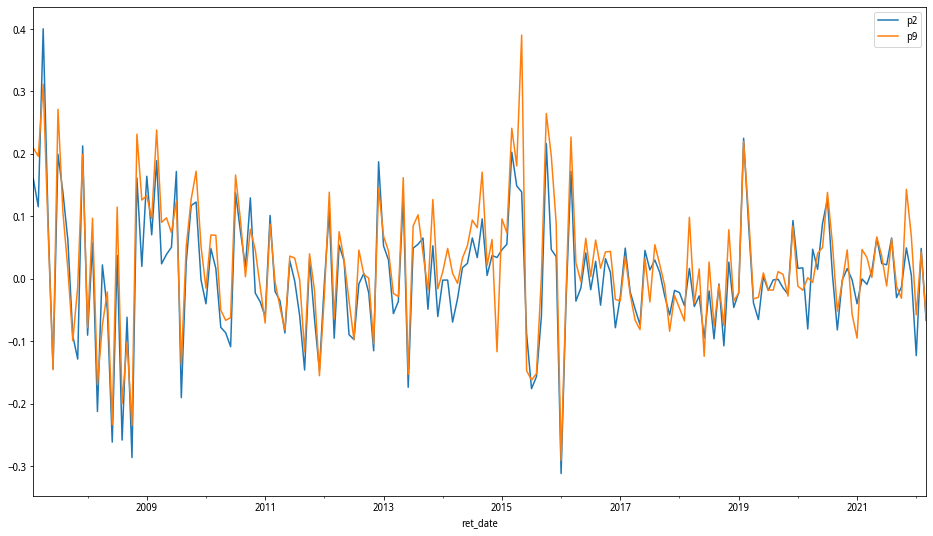

In [61]:
pd.DataFrame(portfolios_crs_mean)[['p2','p9']].plot()

## Double sort

In [62]:
ret_df.rename(columns={'illiq_1m':'illiq'},inplace=True)

In [63]:
from myutils.factor_func import double_sort, factor, daily_factor

In [64]:
double_sort?

Signature:
double_sort(
    df,
    sort1,
    sort2='size',
    group_date='ym',
    merge_cols=['secID', 'ret_date'],
)
Docstring:
Double sorting. 
Arguments:
    sort1: variable 1 for sorting into 3 groups
    sort2: default is "size", sorting into 2 groups
    group_date: the dates upon which the factor exposures are sorted
    merge_cols: the columns
returns:
    portfolios containing 2*3 groups
File:      /srv/data/notes_py3/myutils/factor_func.py
Type:      function


In [65]:
portfolios = double_sort(ret_df, sort1='illiq')

In [66]:
portfolios

{'illiq1_size1':              secID ret_date       ym       ret     exret       size  \
 0      002051.XSHE  2007-07  2007-06  0.084480  0.081998  21.146571   
 1      600578.XSHG  2007-07  2007-06  0.165449  0.162967  21.225388   
 2      000514.XSHE  2007-08  2007-07 -0.124571 -0.126974  21.262089   
 3      000565.XSHE  2007-08  2007-07 -0.107408 -0.109812  21.390840   
 4      000998.XSHE  2007-08  2007-07 -0.005717 -0.008121  21.378763   
 5      002056.XSHE  2007-08  2007-07  0.093693  0.091289  21.355943   
 6      600116.XSHG  2007-08  2007-07 -0.022585 -0.024988  20.899163   
 7      600128.XSHG  2007-08  2007-07  0.349542  0.347138  21.277198   
 ...            ...      ...      ...       ...       ...        ...   
 13421  600227.XSHG  2007-05  2007-04  0.065150  0.062623  21.249363   
 13422  600238.XSHG  2007-05  2007-04  0.052255  0.049727  20.953828   
 13423  600303.XSHG  2007-05  2007-04  0.118673  0.116146  21.231079   
 13424  600377.XSHG  2007-05  2007-04  0.054804 

In [67]:
mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
#     print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有illiq和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['illiq1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,illiq1_size1,illiq1_size2,illiq2_size1,illiq2_size2,illiq3_size1,illiq3_size2
ret_mean,-0.008348,0.005234,0.013319,0.010899,0.020716,0.011809
t_values,-1.081016,0.671160,1.634402,1.439929,2.524040,1.677896


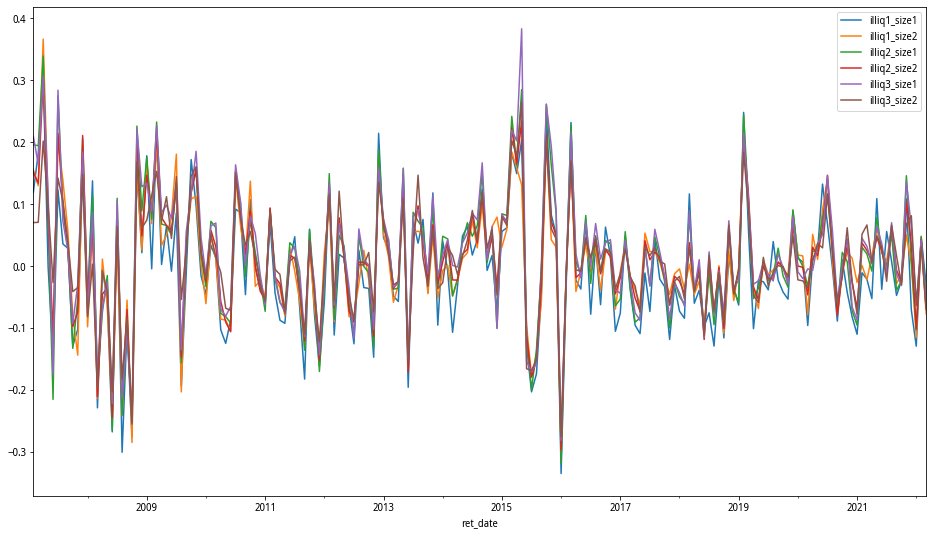

In [68]:
mean_portfolios_ret_df.plot()

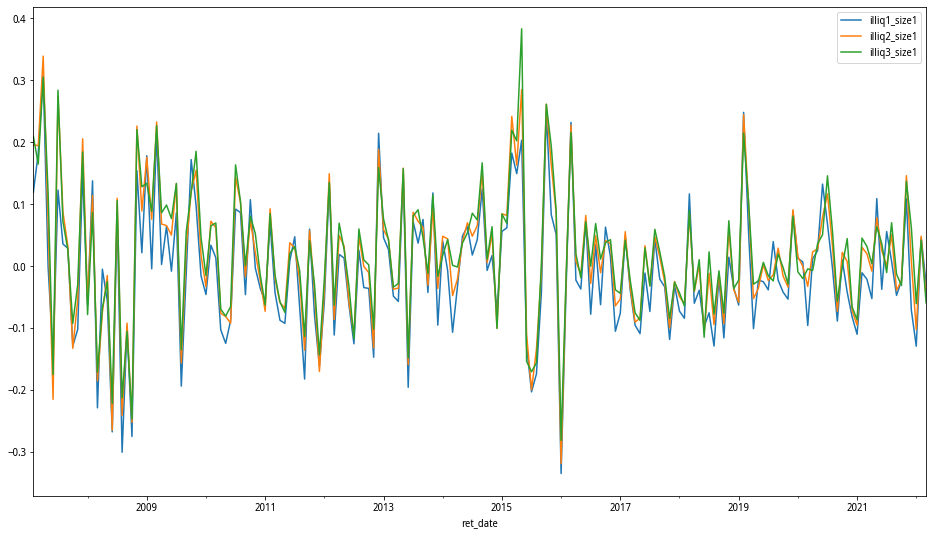

In [69]:
# Within mktcap1, any difference in illiq groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-5:] == 'size1'])
mean_portfolios_ret_df[cols].plot()

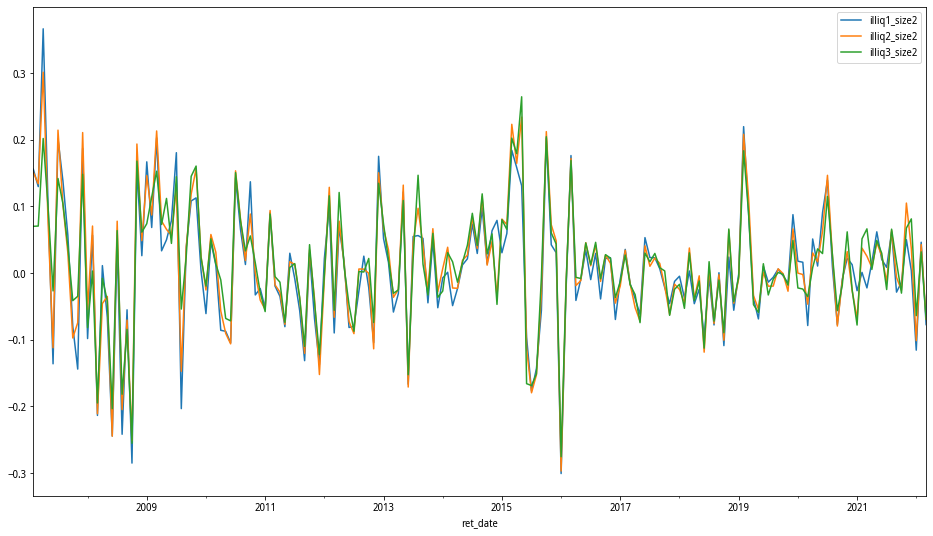

In [70]:
# Within mktcap1, any difference in illiq groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-5:] == 'size2'])
mean_portfolios_ret_df[cols].plot()

## FM regression

In [71]:
def fm_reg(df,cols):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return [None]*(len(cols)+1)
    reg = LinearRegression(fit_intercept=True).fit(y=df_.loc[:,'exret'], X=df_.loc[:,cols])
    return np.insert(reg.coef_, 0, reg.intercept_)

In [72]:
cols = ['illiq']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,illiq
ret_mean,0.000643,16.129001
t_values,0.086762,2.759881


In [73]:
cols = ['beta','size','bm','mom','rev','illiq']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,beta,size,bm,mom,rev,illiq
ret_mean,0.027192,0.000769,-0.001399,0.006144,-0.000687,-0.047483,20.309522
t_values,0.761045,0.166110,-0.978132,1.336325,-0.240611,-5.418059,4.784532


## ST?

以前做上面内容时，先不考虑去除ST，这部分再去除。结论是差不多的。

In [74]:
# # st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")
# # st_df.to_pickle('./data/st_df.pkl')

# ret_df

# st_df = pd.read_pickle('./data/st_df.pkl')

# st_df['ym'] = pd.to_datetime(st_df['tradeDate']).dt.to_period('M')

# st_df.sort_values(['secID','tradeDate'],inplace=True)

# st_df = st_df.groupby(['secID','ym'],as_index=False).last()

# st_df.drop('tradeDate',axis=1,inplace=True)


# st_df

# st_df.loc[st_df['secID']=='000004.XSHE','STflg']

# st_df['STflg'].unique()

# st_df[st_df['STflg'] == '*']

# st_df[~st_df['STflg'].isin(['S'])]

# st_df = st_df[~st_df['STflg'].isin(['S'])]

# st_df

# ret_df[ret_df['secID']=='000004.XSHE']

# ret_df = pd.merge(ret_df,st_df,on=['secID','ym'],how='left')

# ret_df[(ret_df['secID'] =='000004.XSHE') & (ret_df['ym']=='2007-02')]

# ret_df[~ret_df['STflg'].isna()]

# ret_df_exST = ret_df[ret_df['STflg'].isna()]
# ret_df_ST = ret_df[~ret_df['STflg'].isna()]

# ret_df_exST.drop('STflg',axis=1,inplace=True)
# ret_df_ST.drop('STflg',axis=1,inplace=True)

# ret_df.drop('STflg',axis=1,inplace=True)

### Single sort

In [75]:
# q = dict()
# keys = ['q'+str(i) for i in range(1, 10)]
# values = np.arange(0.1, 1.0, 0.1)
# q.update(zip(keys,values))

# quantile_df = pd.DataFrame()
# for key, value in q.items():
#     quantile_df[key] = ret_df_exST.groupby(['ym'])['illiq'].quantile(value)

# ret_df_exST_q = pd.merge(ret_df_exST, quantile_df, on='ym')

# portfolios = dict()
# drop_cols = [col for col in ret_df_exST_q.columns if col[0]=='q']

# portfolios['p1'] = ret_df_exST_q.loc[ret_df_exST_q['illiq'] <= ret_df_exST_q['q1']].copy().drop(drop_cols, axis=1)
# for i in range(2,10):
#     idx = (ret_df_exST_q[f'q{i-1}'] <= ret_df_exST_q['illiq']) & (ret_df_exST_q['illiq'] <= ret_df_exST_q[f'q{i}'])
#     portfolios[f'p{i}'] = ret_df_exST_q.loc[idx].copy().drop(drop_cols, axis=1)
# portfolios['p10'] = ret_df_exST_q.loc[ret_df_exST_q['illiq'] >= ret_df_exST_q['q9']].copy().drop(drop_cols, axis=1)

# portfolios_crs_mean = dict()
# for k in portfolios.keys():
#     portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

# mean_values = {}
# t_values = {}
# for k in portfolios_crs_mean.keys():
#     y = portfolios_crs_mean[k]
#     const = np.full(shape=len(y),fill_value=1)
#     reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
#     mean_values[k] = reg.params[0]
#     t_values[k] = reg.tvalues[0]
# # Portfolio 10-1
# y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
# const = np.full(shape=len(y), fill_value=1)
# reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
# mean_values['p10-p1'] = reg.params[0]
# t_values['p10-p1'] = reg.tvalues[0]

# pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
#              columns=mean_values.keys())

### Double sort

In [76]:
# portfolios = double_sort(ret_df_exST, sort1='illiq')

# mean_portfolios_ret = dict()
# for pf in portfolios.keys():
#     mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
#     print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有illiq和size分组没有任何交叉

In [77]:
# # Fast merge by stacking
# mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
# mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
# mean_portfolios_ret_df.index = mean_portfolios_ret['illiq1_size1'].index

# # Newey-West adjustment
# mean_values = {}
# t_values = {}
# for k in mean_portfolios_ret.keys():
#     y = mean_portfolios_ret[k]
#     const = np.full(shape=len(y),fill_value=1)
#     reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
#     mean_values[k] = reg.params[0]
#     t_values[k] = reg.tvalues[0]

# pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

### FM regression

In [78]:
# cols = ['beta','size','bm','mom','rev','illiq']
# temp = ret_df_exST.groupby('ret_date').apply(fm_reg, cols=cols)
# reg_result_df = pd.DataFrame(temp.values.tolist())
# reg_result_df.index=temp.index
# reg_result_df.columns = ['intercept'] + cols
# reg_result_df.dropna(inplace=True)
# # Mean of coefs with NW adjustment
# mean_values = {}
# t_values = {}
# for k in reg_result_df.columns:
#     y = reg_result_df[k]
#     const = np.full(shape=len(y),fill_value=1)
#     reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
#     mean_values[k] = reg.params[0]
#     t_values[k] = reg.tvalues[0]
# pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

# Illiquidity factor

### Long-short factor

In [79]:
illiq_df = factor(ret_df, sort1='illiq', long_only=False)

In [80]:
illiq_df

ret_date
2007-02    0.044143
2007-03   -0.022646
2007-04   -0.057373
2007-05    0.049768
2007-06    0.015307
2007-07    0.053373
2007-08   -0.027295
2007-09   -0.002890
             ...   
2021-08    0.044309
2021-09    0.033531
2021-10   -0.012598
2021-11    0.037977
2021-12    0.108916
2022-01    0.043099
2022-02    0.002599
2022-03   -0.013360
Freq: M, Name: illiq, Length: 182, dtype: float64

In [81]:
factors_df = pd.read_pickle('./data/factors/ff3_rev.pkl')

In [82]:
factors_df.index = factors_df.index.to_period('M')

In [83]:
factors_df = pd.merge(factors_df,illiq_df,on='ret_date')

In [84]:
factors_df

,exmktret,SMB,HML,rev,illiq
ret_date,,,,,
2008-02,0.024010,0.084902,0.007286,-0.013619,-0.030980
2008-03,-0.195480,0.013640,-0.022060,0.022258,0.020628
2008-04,0.022519,-0.118534,0.024671,0.085249,-0.067934
2008-05,-0.080798,0.063246,-0.001105,0.029831,0.045341
2008-06,-0.236014,-0.029915,-0.003586,-0.009725,0.036767
2008-07,0.014972,0.090890,0.008773,0.053666,0.035619
2008-08,-0.170063,-0.066046,0.032837,0.004892,0.044140
2008-09,-0.067913,-0.033079,0.032129,0.038991,-0.004393
...,...,...,...,...,...


In [85]:
rf_df = ret_df[['ret_date','rf']].drop_duplicates().sort_values('ret_date').dropna()

In [86]:
factors_df = pd.merge(rf_df,factors_df,on='ret_date').set_index('ret_date')

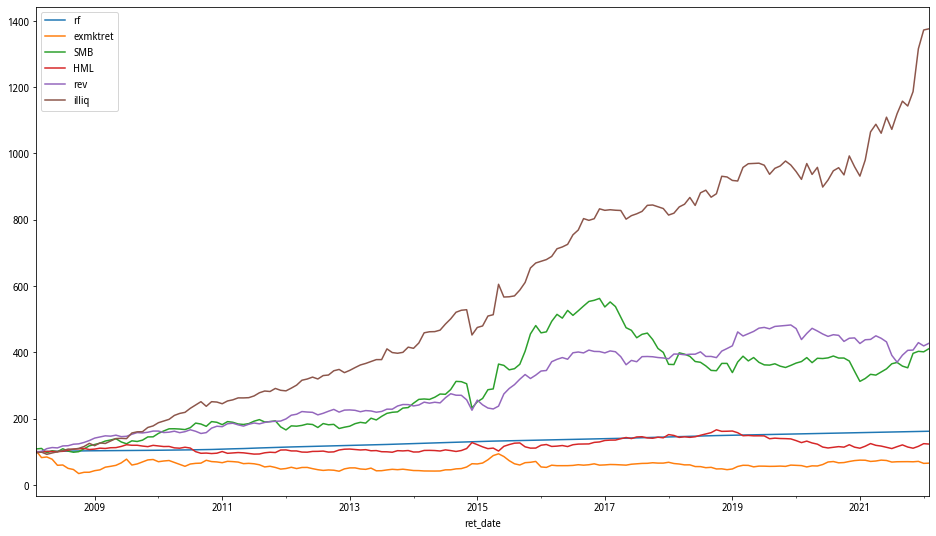

In [87]:
((factors_df+1).cumprod()*100).plot()

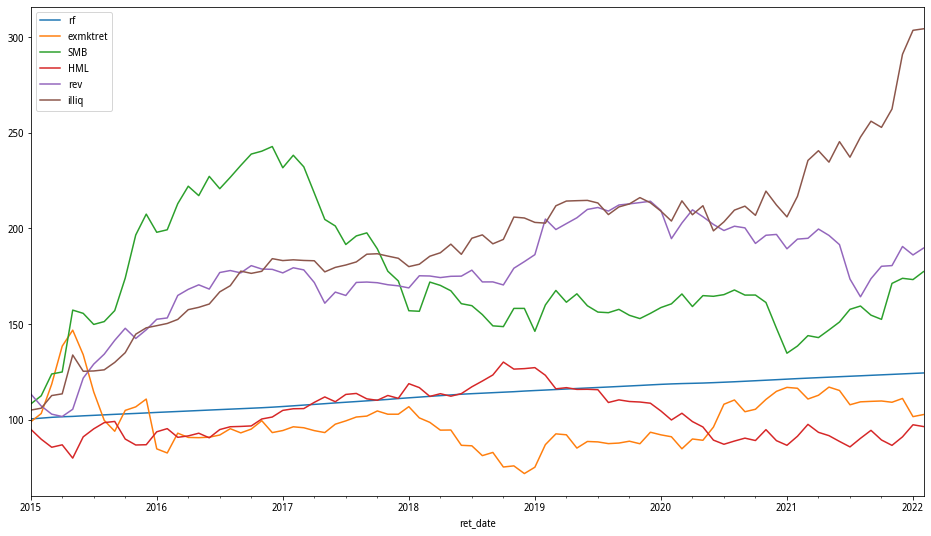

In [88]:
((factors_df['2015':]+1).cumprod()*100).plot()

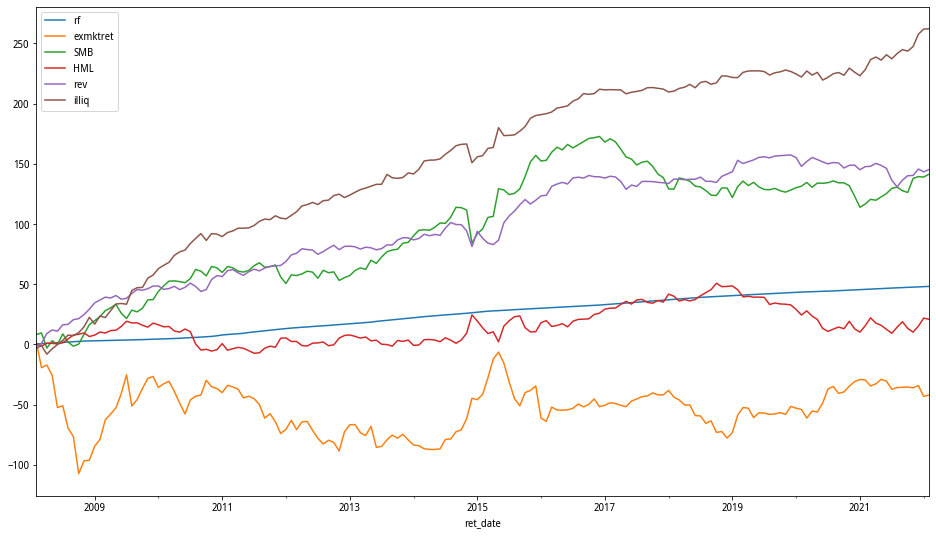

In [89]:
(np.log(1 + factors_df).cumsum()*100).plot()

### Long-only factor

In [90]:
illiq_long_df = factor(ret_df, sort1='illiq')

In [91]:
illiq_long_df

ret_date
2007-02    0.142514
2007-03    0.121996
2007-04    0.249583
2007-05    0.099281
2007-06   -0.091235
2007-07    0.211054
2007-08    0.080601
2007-09    0.036440
             ...   
2021-08    0.066361
2021-09    0.009460
2021-10   -0.021662
2021-11    0.100720
2021-12    0.083863
2022-01   -0.062290
2022-02    0.039255
2022-03   -0.063805
Freq: M, Name: illiq, Length: 182, dtype: float64

In [92]:
factors_long_df = pd.read_pickle('./data/factors/ff3_rev_long_only.pkl')

In [93]:
factors_long_df.index = factors_long_df.index.to_period('M')

In [94]:
factors_long_df = pd.merge(factors_long_df,illiq_long_df,on='ret_date')

In [95]:
factors_long_df = pd.merge(rf_df,factors_long_df,on='ret_date').set_index('ret_date')

In [96]:
factors_long_df.rename(columns={'illiq':'illiq_long'},inplace=True)

In [97]:
factors_long_df

,rf,exmktret,small_only,high_only,rev_long,illiq_long
ret_date,,,,,,
2008-02,0.002946,0.024010,0.106350,0.060789,0.059612,0.048717
2008-03,0.002746,-0.195480,-0.185605,-0.204875,-0.177674,-0.184564
2008-04,0.002862,0.022519,-0.073984,-0.008138,0.026001,-0.039478
2008-05,0.002953,-0.080798,-0.020726,-0.056888,-0.038600,-0.027371
2008-06,0.003113,-0.236014,-0.258596,-0.240880,-0.249542,-0.207909
2008-07,0.002806,0.014972,0.110389,0.072120,0.084431,0.084488
2008-08,0.002681,-0.170063,-0.234635,-0.187086,-0.205410,-0.189043
2008-09,0.002889,-0.067913,-0.088250,-0.068698,-0.063282,-0.080665
...,...,...,...,...,...,...


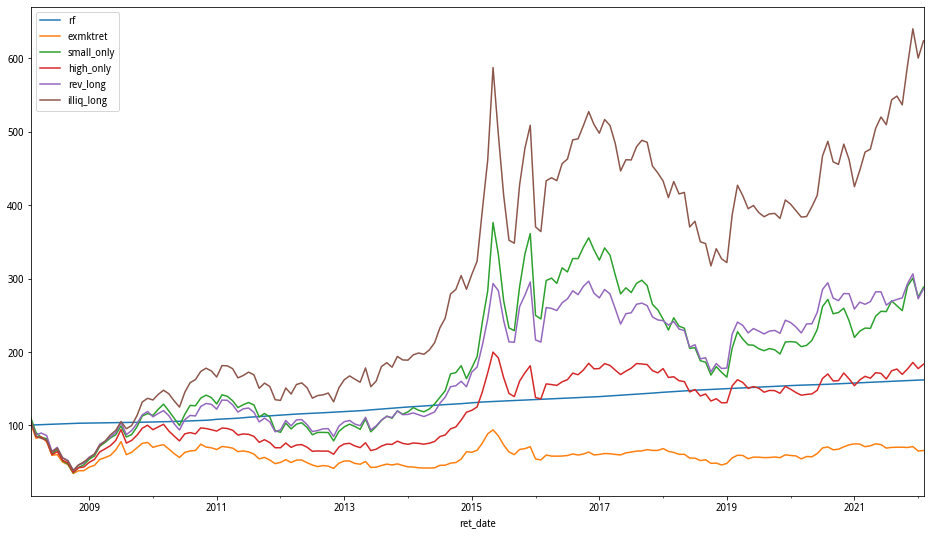

In [98]:
((factors_long_df+1).cumprod()*100).plot()

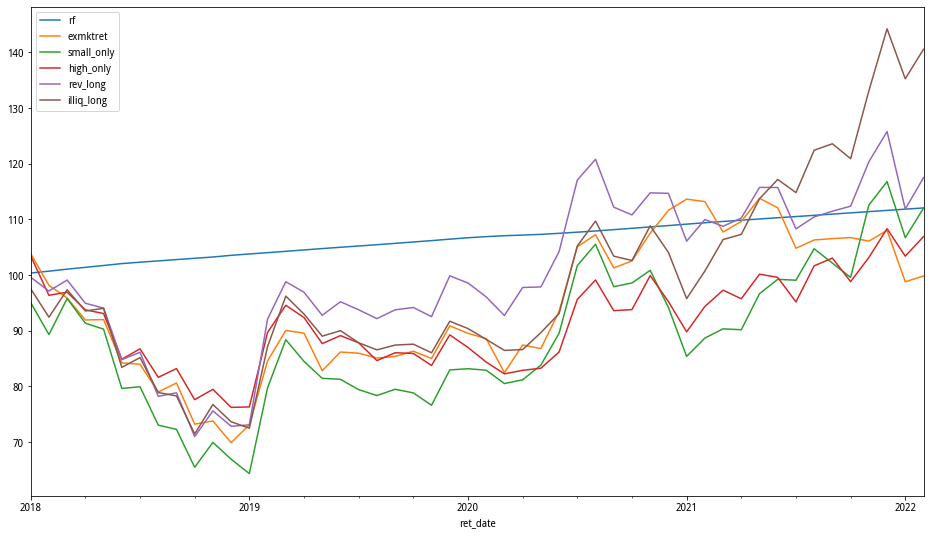

In [99]:
((1 + factors_long_df['2018':]).cumprod()*100).plot()

# Volality

## Raw volatility

In [100]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate,ret_daily,illiq_daily,ym,illiq_250d
0,000001.XSHE,2007-06-20,824.193,987.007,4.835036e+10,4.182345e+09,0.0840,0.197544,4.723272e-11,2007-06,NaN
1,000001.XSHE,2007-06-21,987.007,1085.740,5.318694e+10,2.285485e+09,0.0440,0.100033,4.376871e-11,2007-06,NaN
2,000001.XSHE,2007-06-22,1085.740,1120.233,5.487665e+10,2.761567e+09,0.0510,0.031769,1.150402e-11,2007-06,NaN
3,000001.XSHE,2007-06-25,1120.233,1113.904,5.456661e+10,2.324186e+09,0.0426,-0.005650,2.430837e-12,2007-06,NaN
4,000001.XSHE,2007-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-06,NaN
5,000001.XSHE,2007-06-27,1113.904,1019.602,4.994705e+10,2.446556e+09,0.0489,-0.084659,3.460334e-11,2007-06,NaN
6,000001.XSHE,2007-06-28,1019.602,953.780,4.672266e+10,1.617434e+09,0.0336,-0.064557,3.991295e-11,2007-06,NaN
7,000001.XSHE,2007-06-29,953.780,870.870,4.266117e+10,1.410758e+09,0.0316,-0.086928,6.161781e-11,2007-06,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10182920,900957.XSHG,2022-03-03,0.610,0.614,1.120560e+08,4.576100e+04,0.0004,0.006557,1.432962e-07,2022-03,6.094510e-08


In [101]:
vol_df = stk_df.groupby(['secID','ym'])['ret_daily'].std()

In [102]:
vol_df

secID        ym     
000001.XSHE  2007-06    0.106354
             2007-07    0.042521
             2007-08    0.033926
             2007-09    0.023872
             2007-10    0.035921
             2007-11    0.033184
             2007-12    0.027254
             2008-01    0.037722
                          ...   
900957.XSHG  2021-08    0.012268
             2021-09    0.022351
             2021-10    0.011663
             2021-11    0.009639
             2021-12    0.010961
             2022-01    0.010559
             2022-02    0.006517
             2022-03    0.008522
Name: ret_daily, Length: 507467, dtype: float64

In [103]:
vol_df = vol_df.to_frame()

In [104]:
vol_df.columns = ['vol']
vol_df.reset_index(inplace=True)

MIN_NOBS = 15
idx = stk_df.groupby(['secID','ym'],as_index=False)['tradeDate'].count()['tradeDate'] < MIN_NOBS

vol_df.loc[idx, 'vol'] = np.nan

In [105]:
vol_df

,secID,ym,vol
0,000001.XSHE,2007-06,NaN
1,000001.XSHE,2007-07,0.042521
2,000001.XSHE,2007-08,0.033926
3,000001.XSHE,2007-09,0.023872
4,000001.XSHE,2007-10,0.035921
5,000001.XSHE,2007-11,0.033184
6,000001.XSHE,2007-12,0.027254
7,000001.XSHE,2008-01,0.037722
...,...,...,...
507459,900957.XSHG,2021-08,0.012268


## Idiosyncratic volatility

Idiosyncratic volatility 指的是被已有的因子收益率回归之后，剩下的残差的波动率。传统金融理论认为残差部分属于可分散的风险，不应该被定价。即使认为因子模型还不够好，残差部分有剩余未被解释的系统性风险的部分，这部分的风险溢价(factor risk premium)也应该是正的。然而，美国市场的数据发现，波动率越低，未来的收益越高。这是一个很有意思的异象。

最广为人知的文献是 Ang, Hodrick, Xing, and Zhang (2006)。

- Bali and Cakici (2008): 数据处理的细节对结果影响很大，包括数据频率、portfolio加权的方式、分位点的计算等等
- Huang et al. (2010 RFS): 这个异象和 reversal 有关
- 其他部分文献：Han and Lesmond (2011), Bali, Cakici, and Whitelaw (2011), Baker, Bradley, and Wurgler (2011), Baker and Wurgler (2014)

我们每个月用因子模型计算一下ivol，用来排序。

#### Daily factors

In [106]:
pd.read_pickle('./data/factors/factors_daily.pkl')

,rf,exmktret,size,bm,mom,rev
tradeDate,,,,,,
2007-02-01,0.000048,0.005542,0.000706,0.008284,NaN,NaN
2007-02-02,0.000048,-0.035335,0.017586,0.011413,NaN,NaN
2007-02-05,0.000048,-0.005993,0.019517,0.009377,NaN,NaN
2007-02-06,0.000049,0.019879,0.007078,0.005161,NaN,NaN
2007-02-07,0.000050,0.021923,-0.007519,-0.003939,NaN,NaN
2007-02-08,0.000052,0.017380,0.000016,0.004336,NaN,NaN
2007-02-09,0.000076,-0.003355,0.003784,0.000447,NaN,NaN
2007-02-12,0.000110,0.033455,-0.009223,-0.006304,NaN,NaN
...,...,...,...,...,...,...


In [107]:
shibor1d = DataAPI.MktIborGet(secID="Shibor1D.IRCN",beginDate=START,endDate=END,field=['tradeDate','rate'],pandas="1")
shibor1d['tradeDate'] = pd.to_datetime(shibor1d['tradeDate'])
shibor1d['rate'] = shibor1d['rate'] * 0.01 / 365
shibor1d.rename(columns={'rate':'rf'},inplace=True)

In [108]:
factors_daily = pd.read_pickle('./data/factors/factors_daily.pkl')

In [109]:
illiq_daily = daily_factor(ret_df, stock_df=stk_df,sort1='illiq',long_only=False)

In [110]:
illiq_daily

tradeDate
2007-02-01    0.001867
2007-02-02    0.028347
2007-02-05    0.019764
2007-02-06    0.005676
2007-02-07   -0.010923
2007-02-08    0.008654
2007-02-09    0.001801
2007-02-12   -0.015907
                ...   
2022-03-03    0.004227
2022-03-04   -0.000377
2022-03-07    0.000735
2022-03-08   -0.005731
2022-03-09   -0.011574
2022-03-10   -0.000616
2022-03-11    0.001316
2022-03-14   -0.000970
Name: illiq, Length: 3674, dtype: float64

In [111]:
illiq_daily.name = 'illiq'

In [112]:
factors_daily = pd.merge(factors_daily, illiq_daily, on='tradeDate')

In [113]:
factors_daily

,rf,exmktret,size,bm,mom,rev,illiq
tradeDate,,,,,,,
2007-02-01,0.000048,0.005542,0.000706,0.008284,NaN,NaN,0.001867
2007-02-02,0.000048,-0.035335,0.017586,0.011413,NaN,NaN,0.028347
2007-02-05,0.000048,-0.005993,0.019517,0.009377,NaN,NaN,0.019764
2007-02-06,0.000049,0.019879,0.007078,0.005161,NaN,NaN,0.005676
2007-02-07,0.000050,0.021923,-0.007519,-0.003939,NaN,NaN,-0.010923
2007-02-08,0.000052,0.017380,0.000016,0.004336,NaN,NaN,0.008654
2007-02-09,0.000076,-0.003355,0.003784,0.000447,NaN,NaN,0.001801
2007-02-12,0.000110,0.033455,-0.009223,-0.006304,NaN,NaN,-0.015907
...,...,...,...,...,...,...,...


#### 计算月度的 idiosyncratic volatility

In [114]:
def idiovol_np(df, factor_cols, len_periods='1m', min_nobs=15):
    """
    df: year_month is set as index
    """
    year_months = df.index.unique()
    n = len(year_months)
    idiovol = np.full(shape=n, fill_value=np.nan)
    start_notnan_month = int(len_periods[:-1])-1
    for i in range(start_notnan_month,n):
        df_ = df.loc[str(year_months[i]-int(len_periods[:-1])+1) : str(year_months[i]),['exret']+factor_cols].dropna().to_numpy()
        if len(df_) < min_nobs:
            continue
        else:
            y_ = df_[:,0] # 
            X_ = df_[:,1:]
            reg = LinearRegression().fit(y=y_, X=X_)
            res = y_ - reg.predict(X_)
            idiovol[i] = np.std(res)
    idiovol_df = pd.DataFrame({'ym': year_months, f'idiovol{len_periods}': idiovol})
    return idiovol_df

In [115]:
def idiovol(df,factor_cols,min_nobs=15):
    df = df.dropna()
    y = df.loc[:,'exret']
    X = df.loc[:,factor_cols]
    nobs = len(X)
    if nobs < min_nobs:
        idiovol = np.nan
    else:
        reg = LinearRegression().fit(y=y,X=X)
        res = y - reg.predict(X)
        idiovol = np.std(res)
    return idiovol

In [116]:
reg_df = pd.merge(stk_df[['secID','tradeDate','ret_daily']],factors_daily,
                  on=['tradeDate'])

In [117]:
reg_df

,secID,tradeDate,ret_daily,rf,exmktret,size,bm,mom,rev,illiq
0,000001.XSHE,2007-06-20,0.197544,0.000073,-0.024256,-0.002343,-0.001034,NaN,-0.00205,0.005758
1,000002.XSHE,2007-06-20,-0.035577,0.000073,-0.024256,-0.002343,-0.001034,NaN,-0.00205,0.005758
2,000006.XSHE,2007-06-20,-0.030451,0.000073,-0.024256,-0.002343,-0.001034,NaN,-0.00205,0.005758
3,000007.XSHE,2007-06-20,NaN,0.000073,-0.024256,-0.002343,-0.001034,NaN,-0.00205,0.005758
4,000008.XSHE,2007-06-20,NaN,0.000073,-0.024256,-0.002343,-0.001034,NaN,-0.00205,0.005758
5,000012.XSHE,2007-06-20,-0.066159,0.000073,-0.024256,-0.002343,-0.001034,NaN,-0.00205,0.005758
6,000014.XSHE,2007-06-20,-0.002394,0.000073,-0.024256,-0.002343,-0.001034,NaN,-0.00205,0.005758
7,000016.XSHE,2007-06-20,-0.050821,0.000073,-0.024256,-0.002343,-0.001034,NaN,-0.00205,0.005758
...,...,...,...,...,...,...,...,...,...,...
10157577,900949.XSHG,2007-06-19,0.001454,0.000071,0.009520,0.008649,0.003262,NaN,0.00052,-0.006885


In [118]:
reg_df.sort_values(['secID','tradeDate'],inplace=True)

In [119]:
reg_df

,secID,tradeDate,ret_daily,rf,exmktret,size,bm,mom,rev,illiq
0,000001.XSHE,2007-06-20,0.197544,0.000073,-0.024256,-0.002343,-0.001034,NaN,-0.002050,0.005758
1386,000001.XSHE,2007-06-21,0.100033,0.000064,0.005827,-0.009098,0.002051,NaN,0.007474,-0.014001
2774,000001.XSHE,2007-06-22,0.031769,0.000058,-0.040473,-0.018162,-0.012145,NaN,-0.005785,0.005331
4162,000001.XSHE,2007-06-25,-0.005650,0.000052,-0.048566,-0.018636,-0.015277,NaN,-0.003654,0.004555
5550,000001.XSHE,2007-06-26,NaN,0.000049,0.014660,-0.000007,0.013603,NaN,0.006575,-0.010688
6939,000001.XSHE,2007-06-27,-0.084659,0.000047,0.027391,-0.002884,-0.006621,NaN,-0.004414,-0.007068
8328,000001.XSHE,2007-06-28,-0.064557,0.000046,-0.050035,-0.022858,-0.002255,NaN,0.000980,-0.001477
9717,000001.XSHE,2007-06-29,-0.086928,0.000049,-0.029572,-0.016444,0.006253,NaN,-0.000554,0.000632
...,...,...,...,...,...,...,...,...,...,...
10006447,900957.XSHG,2022-03-03,0.006557,0.000047,-0.005066,0.002299,0.022054,-0.004624,-0.007673,0.004227


In [120]:
reg_df['exret'] = reg_df['ret_daily'] - reg_df['rf']

In [121]:
reg_df['ym'] = reg_df['tradeDate'].dt.to_period('M')

#### 代码测试

In [122]:
# Testing the time consuming 
ids = reg_df['secID'].unique()
ids_ = np.random.choice(ids, 50)
temp = reg_df[reg_df['secID'].isin(ids_)]

In [123]:
temp.set_index('ym',inplace=True)

In [124]:
%%time
result1 = temp.groupby(['secID','ym']).apply(idiovol, factor_cols=['exmktret','size','bm','mom','rev','illiq'])

CPU times: user 23.1 s, sys: 168 ms, total: 23.3 s
Wall time: 23.3 s


In [125]:
%%time
result2 = temp.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size','bm','mom','rev','illiq'])

CPU times: user 19.1 s, sys: 408 ms, total: 19.5 s
Wall time: 19.6 s


In [126]:
result1

secID        ym     
000004.XSHE  2011-06    0.039065
             2011-07    0.024776
             2011-08    0.011382
             2011-09    0.010367
             2011-10    0.006892
             2011-11    0.011735
             2011-12    0.013728
             2012-01    0.014721
                          ...   
688513.XSHG  2021-08    0.014472
             2021-09    0.008163
             2021-10    0.008998
             2021-11    0.009419
             2021-12    0.006190
             2022-01    0.029948
             2022-02    0.021238
             2022-03         NaN
Length: 5807, dtype: float64

In [127]:
result2

ym  idiovol1m
secID                             
000004.XSHE 0   2011-06   0.039065
            1   2011-07   0.024776
            2   2011-08   0.011382
            3   2011-09   0.010367
            4   2011-10   0.006892
            5   2011-11   0.011735
            6   2011-12   0.013728
            7   2012-01   0.014721
...                 ...        ...
688513.XSHG 11  2021-08   0.014472
            12  2021-09   0.008163
            13  2021-10   0.008998
            14  2021-11   0.009419
            15  2021-12   0.006190
            16  2022-01   0.029948
            17  2022-02   0.021238
            18  2022-03        NaN

[5807 rows x 2 columns]

In [128]:
result1 = result1.to_frame().reset_index()
result1.columns = ['secID','ym','r1']

In [129]:
result2 = result2.reset_index().drop('level_1',axis=1)

In [130]:
result = pd.merge(result1, result2, on=['secID','ym'])

In [131]:
result

,secID,ym,r1,idiovol1m
0,000004.XSHE,2011-06,0.039065,0.039065
1,000004.XSHE,2011-07,0.024776,0.024776
2,000004.XSHE,2011-08,0.011382,0.011382
3,000004.XSHE,2011-09,0.010367,0.010367
4,000004.XSHE,2011-10,0.006892,0.006892
5,000004.XSHE,2011-11,0.011735,0.011735
6,000004.XSHE,2011-12,0.013728,0.013728
7,000004.XSHE,2012-01,0.014721,0.014721
...,...,...,...,...
5799,688513.XSHG,2021-08,0.014472,0.014472


In [132]:
(result['r1'] - result['idiovol1m']).sum()

7.37257477290143e-18

In [133]:
result['r1'].to_numpy()

array([0.03906486, 0.02477628, 0.01138195, ..., 0.02994759, 0.02123808,
              nan])

In [134]:
result['idiovol1m'].to_numpy()

array([0.03906486, 0.02477628, 0.01138195, ..., 0.02994759, 0.02123808,
              nan])

In [135]:
np.array_equal(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [136]:
np.allclose(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [137]:
result.fillna(0, inplace=True)

In [138]:
np.array_equal(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [139]:
np.allclose(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

True

#### 实际计算

In [140]:
reg_df.set_index('ym',inplace=True)

In [141]:
reg_df

,secID,tradeDate,ret_daily,rf,exmktret,size,bm,mom,rev,illiq,exret
ym,,,,,,,,,,,
2007-06,000001.XSHE,2007-06-20,0.197544,0.000073,-0.024256,-0.002343,-0.001034,NaN,-0.002050,0.005758,0.197470
2007-06,000001.XSHE,2007-06-21,0.100033,0.000064,0.005827,-0.009098,0.002051,NaN,0.007474,-0.014001,0.099969
2007-06,000001.XSHE,2007-06-22,0.031769,0.000058,-0.040473,-0.018162,-0.012145,NaN,-0.005785,0.005331,0.031711
2007-06,000001.XSHE,2007-06-25,-0.005650,0.000052,-0.048566,-0.018636,-0.015277,NaN,-0.003654,0.004555,-0.005702
2007-06,000001.XSHE,2007-06-26,NaN,0.000049,0.014660,-0.000007,0.013603,NaN,0.006575,-0.010688,NaN
2007-06,000001.XSHE,2007-06-27,-0.084659,0.000047,0.027391,-0.002884,-0.006621,NaN,-0.004414,-0.007068,-0.084706
2007-06,000001.XSHE,2007-06-28,-0.064557,0.000046,-0.050035,-0.022858,-0.002255,NaN,0.000980,-0.001477,-0.064602
2007-06,000001.XSHE,2007-06-29,-0.086928,0.000049,-0.029572,-0.016444,0.006253,NaN,-0.000554,0.000632,-0.086977
...,...,...,...,...,...,...,...,...,...,...,...


In [142]:
# %%time
# ivol = reg_df.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size','bm','mom','rev','illiq'])
# # Takes about 26min 40s to execute

In [143]:
# ivol = ivol.reset_index().drop('level_1',axis=1)

In [144]:
# ivol.to_pickle('./data/idiovol1m.pkl')

In [145]:
ivol = pd.read_pickle('./data/idiovol1m.pkl')

In [146]:
vol_df = pd.merge(vol_df,ivol,on=['secID','ym'])

In [147]:
vol_df

,secID,ym,vol,idiovol1m
0,000001.XSHE,2007-06,NaN,NaN
1,000001.XSHE,2007-07,0.042521,NaN
2,000001.XSHE,2007-08,0.033926,NaN
3,000001.XSHE,2007-09,0.023872,NaN
4,000001.XSHE,2007-10,0.035921,NaN
5,000001.XSHE,2007-11,0.033184,NaN
6,000001.XSHE,2007-12,0.027254,NaN
7,000001.XSHE,2008-01,0.037722,0.013266
...,...,...,...,...
504872,900957.XSHG,2021-08,0.012268,0.008334


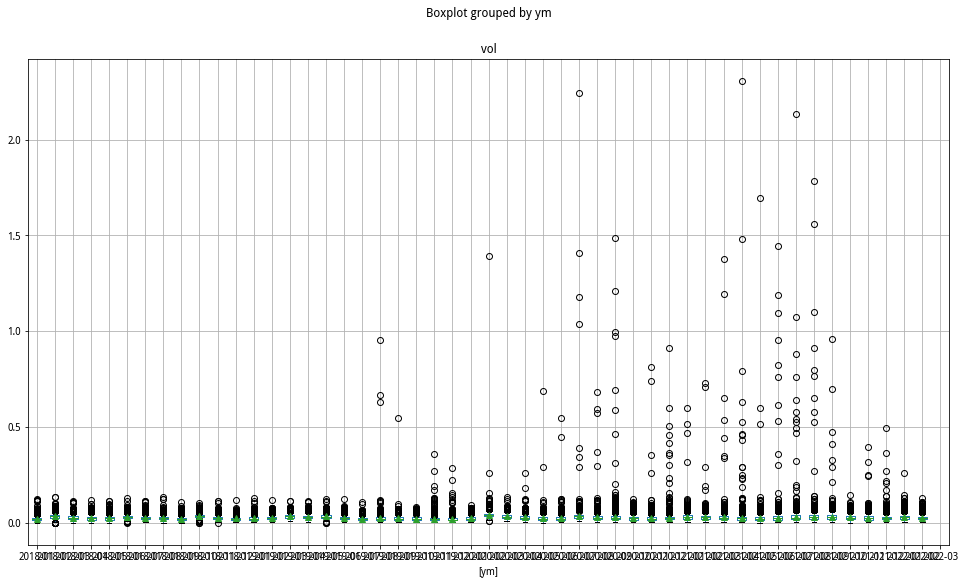

In [148]:
vol_df.loc[vol_df['ym']>='2018',['ym','vol']].boxplot(by='ym',showmeans=True)

In [149]:
vol_df['vol_clip'] = vol_df['vol'].clip(lower=vol_df['vol'].quantile(0.001),
                                        upper=vol_df['vol'].quantile(0.999))
vol_df['ivol_clip'] = vol_df['idiovol1m'].clip(lower=vol_df['idiovol1m'].quantile(0.001),
                                               upper=vol_df['idiovol1m'].quantile(0.999))

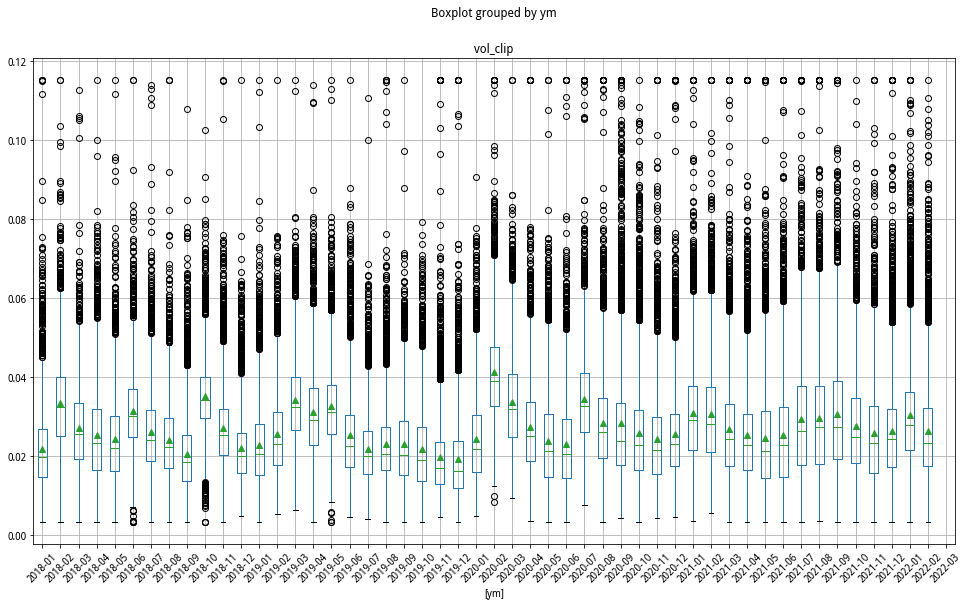

In [150]:
vol_df.loc[vol_df['ym']>='2018',['ym','vol_clip']].boxplot(by='ym',showmeans=True,rot=45)

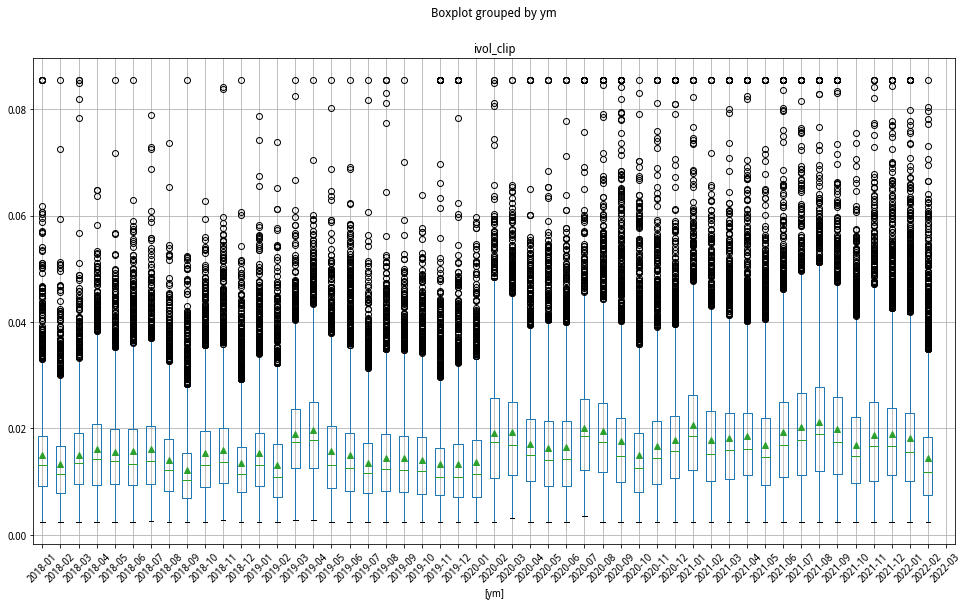

In [151]:
vol_df.loc[vol_df['ym']>='2018',['ym','ivol_clip']].boxplot(by='ym',showmeans=True,rot=45)

In [152]:
vol_df.loc[:,'vol':'ivol_clip'].describe()

,vol,idiovol1m,vol_clip,ivol_clip
count,474098.000000,450202.000000,474098.000000,450202.000000
mean,0.028640,0.016197,0.028407,0.016041
std,0.021900,0.015088,0.013900,0.009217
min,0.000001,0.000015,0.003336,0.002371
25%,0.018469,0.009486,0.018469,0.009486
50%,0.025640,0.014014,0.025640,0.014014
75%,0.035408,0.020517,0.035408,0.020517
max,4.874535,3.338409,0.115134,0.085371


In [153]:
vol_df.rename(columns={'idiovol1m':'ivol'},inplace=True)

## Sorting and Factors

In [154]:
ret_df = pd.merge(ret_df,vol_df,
                  on=['secID','ym'])

In [155]:
ret_df

,secID,ret_date,ret,rf,exret,ym,mktcap,size,rev,beta,bm,illiq,illiq_12m,mom_date,mom,vol,ivol,vol_clip,ivol_clip
0,000001.XSHE,2007-07,0.316497,0.002481,0.314016,2007-06,4.266117e+10,24.476555,NaN,0.4614,0.123739,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,000001.XSHE,2007-08,0.048855,0.002404,0.046451,2007-07,5.616330e+10,24.751529,0.314016,0.6423,0.093992,0.000040,NaN,2007-06,NaN,0.042521,NaN,0.042521,NaN
2,000001.XSHE,2007-09,0.052105,0.002621,0.049484,2007-08,5.890714e+10,24.799228,0.046451,0.7722,0.097085,0.000020,NaN,2007-07,NaN,0.033926,NaN,0.033926,NaN
3,000001.XSHE,2007-10,0.201851,0.003095,0.198756,2007-09,6.197651e+10,24.850021,0.049484,0.7596,0.092276,0.000025,NaN,2007-08,NaN,0.023872,NaN,0.023872,NaN
4,000001.XSHE,2007-11,-0.249116,0.003780,-0.252896,2007-10,7.448652e+10,25.033884,0.198756,0.7988,0.083411,0.000030,NaN,2007-09,NaN,0.035921,NaN,0.035921,NaN
5,000001.XSHE,2007-12,0.069845,0.003011,0.066834,2007-11,5.593078e+10,24.747381,-0.252896,0.9560,0.111084,0.000048,NaN,2007-10,NaN,0.033184,NaN,0.033184,NaN
6,000001.XSHE,2008-01,-0.137306,0.002949,-0.140255,2007-12,6.574629e+10,24.909069,0.066834,0.9468,0.094476,0.000025,NaN,2007-11,NaN,0.027254,NaN,0.027254,NaN
7,000001.XSHE,2008-02,-0.004504,0.002946,-0.007450,2008-01,5.850212e+10,24.792329,-0.140255,0.9654,0.109513,0.000039,NaN,2007-12,NaN,0.037722,0.013266,0.037722,0.013266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504872,900957.XSHG,2021-09,0.089869,0.002033,0.087837,2021-08,1.116880e+08,18.531220,-0.060402,NaN,NaN,0.067321,0.071830,2021-07,0.183971,0.012268,0.008334,0.012268,0.008334


In [156]:
def single_sort(df, sort):
    q = dict()
    keys = ['q'+str(i) for i in range(1, 10)]
    values = np.arange(0.1, 1.0, 0.1)
    q.update(zip(keys,values))

    quantile_df = pd.DataFrame()
    for key, value in q.items():
        quantile_df[key] = df.groupby(['ym'])[sort].quantile(value)

    df_q = pd.merge(df, quantile_df, on='ym')

    portfolios = dict()
    drop_cols = [col for col in df_q.columns if col[0]=='q']

    portfolios['p1'] = df_q.loc[df_q[sort] <= df_q['q1']].copy().drop(drop_cols, axis=1)
    for i in range(2,10):
        idx = (df_q[f'q{i-1}'] <= df_q[sort]) & (df_q[sort] <= df_q[f'q{i}'])
        portfolios[f'p{i}'] = df_q.loc[idx].copy().drop(drop_cols, axis=1)
    portfolios['p10'] = df_q.loc[df_q[sort] >= df_q['q9']].copy().drop(drop_cols, axis=1)

    portfolios_crs_mean = dict()
    for k in portfolios.keys():
        portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

    mean_values = {}
    t_values = {}
    for k in portfolios_crs_mean.keys():
        y = portfolios_crs_mean[k]
        const = np.full(shape=len(y),fill_value=1)
        reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
        mean_values[k] = reg.params[0]
        t_values[k] = reg.tvalues[0]
    # Portfolio 10-1
    y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
    const = np.full(shape=len(y), fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values['p10-p1'] = reg.params[0]
    t_values['p10-p1'] = reg.tvalues[0]

    display(pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
                 columns=mean_values.keys()))

### Raw volatility

In [157]:
single_sort(ret_df, 'vol')

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p10-p1
mean,0.007337,0.011287,0.013814,0.014053,0.014017,0.013851,0.011587,0.010645,0.006654,-0.000991,-0.008328
t-value,1.056233,1.569362,1.813114,1.869054,1.816930,1.822467,1.502884,1.338801,0.838907,-0.125213,-2.600835


In [158]:
portfolios = double_sort(ret_df, sort1='vol')

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有vol和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['vol1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(180,)
(180,)
(180,)
(180,)
(180,)
(180,)


,vol1_size1,vol1_size2,vol2_size1,vol2_size2,vol3_size1,vol3_size2
ret_mean,0.014703,0.007517,0.017610,0.008821,0.009058,0.001977
t_values,1.921385,1.094163,2.259663,1.162678,1.108706,0.253048


In [159]:
cols = ['beta','size','bm','mom','rev','illiq','vol']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,beta,size,bm,mom,rev,illiq,vol
ret_mean,0.031483,0.003531,-0.001411,0.003809,0.001118,-0.035448,19.502446,-0.299493
t_values,0.972914,0.790855,-1.081678,0.877997,0.397948,-3.569641,4.616724,-3.015234


In [160]:
cols = ['beta','size','bm','mom','rev','illiq','vol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,beta,size,bm,mom,rev,illiq,vol_clip
ret_mean,0.031500,0.003531,-0.001411,0.003808,0.001119,-0.035439,19.501013,-0.299633
t_values,0.973331,0.790949,-1.081959,0.877754,0.398310,-3.568468,4.616183,-3.016512


### Idiosyncratic volatility

In [161]:
single_sort(ret_df, 'ivol')

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p10-p1
mean,0.010668,0.011995,0.012429,0.011129,0.010464,0.009694,0.007346,0.004945,0.001674,-0.006201,-0.016869
t-value,1.538742,1.613262,1.617754,1.490069,1.404011,1.305279,0.978722,0.664192,0.221387,-0.793998,-6.567733


In [162]:
portfolios = double_sort(ret_df, sort1='ivol')

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有vol和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['ivol1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(170,)
(170,)
(170,)
(170,)
(170,)
(170,)


,ivol1_size1,ivol1_size2,ivol2_size1,ivol2_size2,ivol3_size1,ivol3_size2
ret_mean,0.016951,0.006678,0.014572,0.004941,0.002843,-0.002479
t_values,2.205019,0.944435,1.830346,0.679304,0.354149,-0.331019


In [163]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,beta,size,bm,mom,rev,illiq,ivol_clip
ret_mean,0.055781,0.001059,-0.002146,0.001017,0.001587,-0.025464,17.950779,-0.702537
t_values,1.574320,0.231355,-1.522884,0.226575,0.548174,-2.778320,4.360190,-10.197885


In [164]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df[ret_df['ret_date']>='2015'].groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,beta,size,bm,mom,rev,illiq,ivol_clip
ret_mean,0.055272,-0.000577,-0.001813,-0.001160,0.002554,-0.024553,21.185018,-0.669158
t_values,0.960013,-0.153607,-0.799253,-0.203454,0.873940,-1.669428,2.815058,-7.027257


In [165]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df[ret_df['ret_date']>='2018'].groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,beta,size,bm,mom,rev,illiq,ivol_clip
ret_mean,0.023425,0.004291,-0.000744,-0.002097,0.005124,-0.009445,5.764173,-0.588946
t_values,0.432546,1.043547,-0.351152,-0.368813,1.478403,-0.632979,1.667127,-6.459679


In [166]:
ivol_factor = factor(ret_df, sort1='ivol',long_high=False,long_only=False)

In [167]:
ivol_factor

ret_date
2008-02   -0.018666
2008-03    0.042088
2008-04    0.001841
2008-05   -0.020607
2008-06    0.022669
2008-07    0.004234
2008-08    0.082000
2008-09   -0.042538
             ...   
2021-08    0.002384
2021-09    0.097063
2021-10    0.006843
2021-11   -0.030690
2021-12    0.086668
2022-01    0.078084
2022-02   -0.014953
2022-03    0.002251
Freq: M, Name: ivol, Length: 170, dtype: float64

In [168]:
factors_df = pd.merge(factors_df,ivol_factor,on='ret_date',how='left')

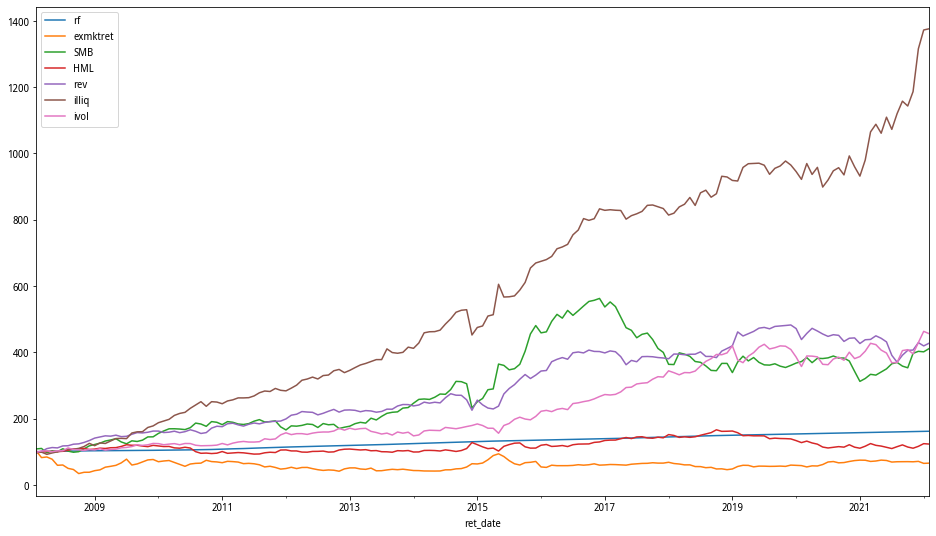

In [169]:
((factors_df+1).cumprod()*100).plot()

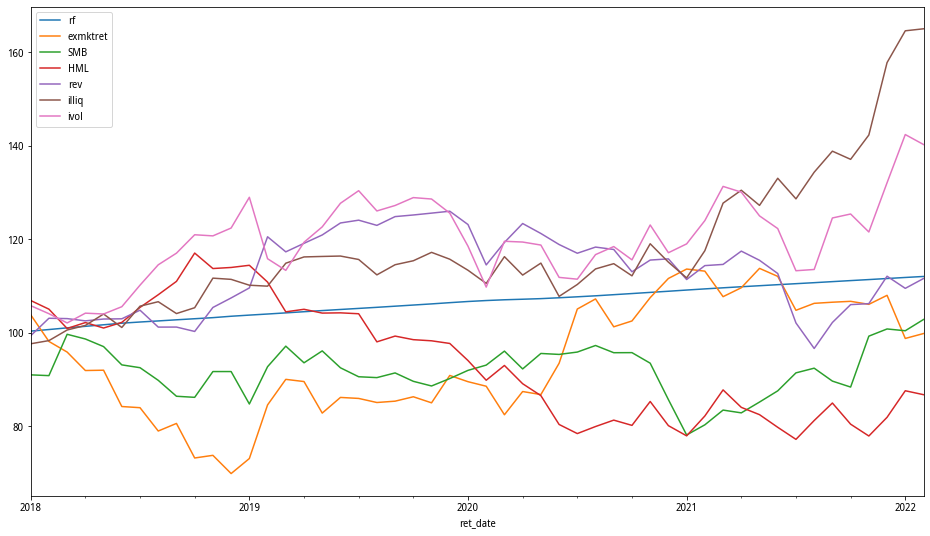

In [170]:
((factors_df['2018':]+1).cumprod()*100).plot()

In [171]:
factors_df.to_pickle('./data/factors/factors_all.pkl')

## Output factor exposures

In [172]:
ret_df

,secID,ret_date,ret,rf,exret,ym,mktcap,size,rev,beta,bm,illiq,illiq_12m,mom_date,mom,vol,ivol,vol_clip,ivol_clip
0,000001.XSHE,2007-07,0.316497,0.002481,0.314016,2007-06,4.266117e+10,24.476555,NaN,0.4614,0.123739,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,000001.XSHE,2007-08,0.048855,0.002404,0.046451,2007-07,5.616330e+10,24.751529,0.314016,0.6423,0.093992,0.000040,NaN,2007-06,NaN,0.042521,NaN,0.042521,NaN
2,000001.XSHE,2007-09,0.052105,0.002621,0.049484,2007-08,5.890714e+10,24.799228,0.046451,0.7722,0.097085,0.000020,NaN,2007-07,NaN,0.033926,NaN,0.033926,NaN
3,000001.XSHE,2007-10,0.201851,0.003095,0.198756,2007-09,6.197651e+10,24.850021,0.049484,0.7596,0.092276,0.000025,NaN,2007-08,NaN,0.023872,NaN,0.023872,NaN
4,000001.XSHE,2007-11,-0.249116,0.003780,-0.252896,2007-10,7.448652e+10,25.033884,0.198756,0.7988,0.083411,0.000030,NaN,2007-09,NaN,0.035921,NaN,0.035921,NaN
5,000001.XSHE,2007-12,0.069845,0.003011,0.066834,2007-11,5.593078e+10,24.747381,-0.252896,0.9560,0.111084,0.000048,NaN,2007-10,NaN,0.033184,NaN,0.033184,NaN
6,000001.XSHE,2008-01,-0.137306,0.002949,-0.140255,2007-12,6.574629e+10,24.909069,0.066834,0.9468,0.094476,0.000025,NaN,2007-11,NaN,0.027254,NaN,0.027254,NaN
7,000001.XSHE,2008-02,-0.004504,0.002946,-0.007450,2008-01,5.850212e+10,24.792329,-0.140255,0.9654,0.109513,0.000039,NaN,2007-12,NaN,0.037722,0.013266,0.037722,0.013266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504872,900957.XSHG,2021-09,0.089869,0.002033,0.087837,2021-08,1.116880e+08,18.531220,-0.060402,NaN,NaN,0.067321,0.071830,2021-07,0.183971,0.012268,0.008334,0.012268,0.008334


In [173]:
ret_df.to_pickle('./data/factor_exposure/all_exposure.pkl')

In [210]:
cols = ['size','bm','rev','illiq','ivol']

In [211]:
monthend = stk_df[['secID','tradeDate','ym']].groupby(['secID','ym'],as_index=False).last()
monthend.rename(columns={'tradeDate':'month_end'},inplace=True)

In [212]:
ret_df = pd.merge(ret_df, monthend,on=['secID','ym'],how='left')

In [213]:
ret_df['month_end'] = ret_df['ym'].dt.to_timestamp() + pd.tseries.offsets.MonthEnd(0)

In [216]:
ret_df[['secID','month_end','rev']].dropna().pivot(index='month_end',
                                                columns='secID',values='rev')

secID,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,900947.XSHG,900948.XSHG,900949.XSHG,900950.XSHG,900951.XSHG,900952.XSHG,900953.XSHG,900955.XSHG,900956.XSHG,900957.XSHG
month_end,,,,,,,,,,,,,,,,,,,,,
2007-03-31,NaN,0.123274,NaN,NaN,0.101648,0.31873,0.177471,NaN,NaN,NaN,...,-0.014794,-0.099864,0.017183,0.036083,-0.016418,0.021524,-0.099523,0.067198,-0.121383,-0.079664
2007-04-30,NaN,0.087689,NaN,NaN,0.418516,0.20470,NaN,NaN,NaN,NaN,...,0.124424,0.653910,0.304224,0.303130,0.189722,0.218339,0.091515,0.240708,0.179840,0.169304
2007-05-31,NaN,0.618401,NaN,NaN,0.327713,NaN,NaN,NaN,NaN,NaN,...,0.058344,0.204421,0.289089,0.837055,0.709746,0.246392,0.582287,0.490010,0.941614,0.439546
2007-06-30,NaN,-0.017483,NaN,NaN,-0.065749,NaN,NaN,NaN,NaN,NaN,...,0.035870,0.094611,-0.200566,-0.301740,-0.356243,-0.223995,-0.349127,-0.181178,-0.193852,-0.321781
2007-07-31,0.314016,0.477643,NaN,NaN,0.282658,NaN,NaN,NaN,NaN,NaN,...,0.155534,0.715471,0.296052,0.465218,0.395700,0.267741,0.435896,0.112073,0.327674,0.351556
2007-08-31,0.046451,0.191943,NaN,NaN,-0.032089,NaN,NaN,NaN,NaN,NaN,...,0.000887,0.135793,-0.097706,-0.062498,0.096426,-0.023398,-0.079410,-0.005383,-0.104684,-0.049422
2007-09-30,0.049484,-0.109130,NaN,NaN,0.140694,NaN,NaN,NaN,NaN,NaN,...,0.282851,0.463506,0.043310,0.071338,0.253000,0.063140,0.090211,0.037718,0.047451,0.062361
2007-10-31,0.198756,0.285979,NaN,NaN,0.049019,NaN,NaN,NaN,NaN,NaN,...,0.238910,0.326724,-0.048441,-0.106393,-0.184998,-0.105710,-0.133202,0.070625,-0.075658,-0.131908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [226]:
temp = ret_df[['secID','month_end','size']].dropna().pivot(index='month_end',
                                                columns='secID',values='size').reset_index()
temp['month_end'] = temp['month_end'].dt.strftime('%Y/%m/%d')
temp.set_index('month_end')

secID,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,900947.XSHG,900948.XSHG,900949.XSHG,900950.XSHG,900951.XSHG,900952.XSHG,900953.XSHG,900955.XSHG,900956.XSHG,900957.XSHG
month_end,,,,,,,,,,,,,,,,,,,,,
2007/03/31,NaN,24.712034,NaN,NaN,21.858822,20.216174,19.582993,NaN,NaN,NaN,...,20.714548,19.804632,20.131555,19.252704,17.546012,18.456098,18.696493,18.539707,18.079176,18.443459
2007/04/30,NaN,24.798040,NaN,NaN,22.209934,20.404169,NaN,NaN,NaN,NaN,...,20.833662,20.309031,20.399086,19.519184,17.721515,18.655302,18.785324,18.757367,18.245732,18.601201
2007/05/31,NaN,25.274487,NaN,NaN,22.482926,NaN,NaN,NaN,NaN,NaN,...,20.892755,20.497155,20.655265,20.128804,18.259338,18.876976,19.245908,19.157845,18.911100,18.967507
2007/06/30,24.476555,25.259434,NaN,NaN,22.417635,NaN,NaN,NaN,NaN,NaN,...,20.930475,20.582292,20.410471,19.773273,17.822844,18.627005,18.819725,18.960677,18.698464,18.582595
2007/07/31,24.751529,25.651961,NaN,NaN,22.668582,NaN,NaN,NaN,NaN,NaN,...,21.067153,21.123389,20.671383,20.156894,18.158016,18.866331,19.184100,19.069301,18.983748,18.885421
2007/08/31,24.799228,25.892469,NaN,NaN,22.638445,NaN,NaN,NaN,NaN,NaN,...,21.070424,21.252823,20.571338,20.094995,18.252262,18.844696,19.103778,19.066422,18.875983,18.836862
2007/09/30,24.850021,25.779850,NaN,NaN,22.772379,NaN,NaN,NaN,NaN,NaN,...,21.321531,21.635482,20.616104,20.166287,18.479893,18.908247,19.193009,19.105997,18.925086,18.900338
2007/10/31,25.033884,26.033773,NaN,NaN,22.823179,NaN,NaN,NaN,NaN,NaN,...,21.538268,21.920527,20.569730,20.057347,18.279117,18.799968,19.052803,19.177131,18.849374,18.762567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [231]:
for c in cols:
    temp = ret_df[['secID','month_end',c]].dropna().pivot(index='month_end',columns='secID',values=c)
    temp.reset_index(inplace=True)
    temp['month_end'] = temp['month_end'].dt.strftime('%Y/%m/%d')
    temp.set_index('month_end',inplace=True)
    temp.to_csv(f'./data/factor_exposure/{c}_exposure.csv')

## Long-only ivol factor

In [181]:
factors_daily = pd.read_pickle('./data/factors/factors_daily_long_only.pkl')
illiq_daily = daily_factor(ret_df, stock_df=stk_df,sort1='illiq',long_only=True)
illiq_daily.name = 'illiq_long'
factors_daily = pd.merge(factors_daily, illiq_daily, on='tradeDate')

In [182]:
reg_df = pd.merge(stk_df[['secID','tradeDate','ret_daily']],factors_daily,
                  on=['tradeDate'])
reg_df.sort_values(['secID','tradeDate'],inplace=True)
reg_df['exret'] = reg_df['ret_daily'] - reg_df['rf']
reg_df['ym'] = reg_df['tradeDate'].dt.to_period('M')

In [183]:
reg_df.set_index('ym',inplace=True)

In [184]:
reg_df

,secID,tradeDate,ret_daily,rf,exmktret,size_long,bm_long,mom_long,rev_long,illiq_long,exret
ym,,,,,,,,,,,
2007-06,000001.XSHE,2007-06-20,0.197544,0.000073,-0.024256,-0.027029,-0.025533,NaN,-0.024584,-0.024601,0.197470
2007-06,000001.XSHE,2007-06-21,0.100033,0.000064,0.005827,-0.004542,0.000369,NaN,0.000862,-0.009814,0.099969
2007-06,000001.XSHE,2007-06-22,0.031769,0.000058,-0.040473,-0.061950,-0.060371,NaN,-0.057584,-0.049115,0.031711
2007-06,000001.XSHE,2007-06-25,-0.005650,0.000052,-0.048566,-0.070613,-0.069931,NaN,-0.063314,-0.051485,-0.005702
2007-06,000001.XSHE,2007-06-26,NaN,0.000049,0.014660,0.018252,0.025202,NaN,0.021496,0.025165,NaN
2007-06,000001.XSHE,2007-06-27,-0.084659,0.000047,0.027391,0.025271,0.023170,NaN,0.024400,0.021623,-0.084706
2007-06,000001.XSHE,2007-06-28,-0.064557,0.000046,-0.050035,-0.072672,-0.062050,NaN,-0.061028,-0.054388,-0.064602
2007-06,000001.XSHE,2007-06-29,-0.086928,0.000049,-0.029572,-0.049163,-0.038645,NaN,-0.043609,-0.032912,-0.086977
...,...,...,...,...,...,...,...,...,...,...,...


In [185]:
gc.collect()

982

In [186]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [187]:
# del stk_unfilled_df, beta_df

In [188]:
# %%time
# ivol = reg_df.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size_long','bm_long','mom_long','rev_long','illiq_long'])
# # Takes about 27min 25s to execute

In [189]:
# ivol = ivol.reset_index().drop('level_1',axis=1)
# display(ivol)
# ivol.to_pickle('./data/idiovol1m_long_only.pkl')

In [190]:
vol_df = stk_df.groupby(['secID','ym'])['ret_daily'].std()
vol_df = vol_df.to_frame()
vol_df.columns = ['vol']
vol_df.reset_index(inplace=True)
MIN_NOBS = 15
idx = stk_df.groupby(['secID','ym'],as_index=False)['tradeDate'].count()['tradeDate'] < MIN_NOBS
vol_df.loc[idx, 'vol'] = np.nan

In [191]:
ivol = pd.read_pickle('./data/idiovol1m_long_only.pkl')
vol_df = pd.merge(vol_df,ivol,on=['secID','ym'])
vol_df['vol_clip'] = vol_df['vol'].clip(lower=vol_df['vol'].quantile(0.001),
                                        upper=vol_df['vol'].quantile(0.999))
vol_df['ivol_clip'] = vol_df['idiovol1m'].clip(lower=vol_df['idiovol1m'].quantile(0.001),
                                               upper=vol_df['idiovol1m'].quantile(0.999))
vol_df.rename(columns={'idiovol1m':'ivol'},inplace=True)

In [192]:
try:
    ret_df.drop(['vol','ivol','vol_clip','ivol_clip'],axis=1,inplace=True)
except KeyError:
    pass

In [193]:
ret_df = pd.merge(ret_df,vol_df,
                  on=['secID','ym'])

In [194]:
ret_df

,secID,ret_date,ret,rf,exret,ym,mktcap,size,rev,beta,bm,illiq,illiq_12m,mom_date,mom,month_end,vol,ivol,vol_clip,ivol_clip
0,000001.XSHE,2007-07,0.316497,0.002481,0.314016,2007-06,4.266117e+10,24.476555,NaN,0.4614,0.123739,NaN,NaN,NaT,NaN,2007-06-30,NaN,NaN,NaN,NaN
1,000001.XSHE,2007-08,0.048855,0.002404,0.046451,2007-07,5.616330e+10,24.751529,0.314016,0.6423,0.093992,0.000040,NaN,2007-06,NaN,2007-07-31,0.042521,NaN,0.042521,NaN
2,000001.XSHE,2007-09,0.052105,0.002621,0.049484,2007-08,5.890714e+10,24.799228,0.046451,0.7722,0.097085,0.000020,NaN,2007-07,NaN,2007-08-31,0.033926,NaN,0.033926,NaN
3,000001.XSHE,2007-10,0.201851,0.003095,0.198756,2007-09,6.197651e+10,24.850021,0.049484,0.7596,0.092276,0.000025,NaN,2007-08,NaN,2007-09-30,0.023872,NaN,0.023872,NaN
4,000001.XSHE,2007-11,-0.249116,0.003780,-0.252896,2007-10,7.448652e+10,25.033884,0.198756,0.7988,0.083411,0.000030,NaN,2007-09,NaN,2007-10-31,0.035921,NaN,0.035921,NaN
5,000001.XSHE,2007-12,0.069845,0.003011,0.066834,2007-11,5.593078e+10,24.747381,-0.252896,0.9560,0.111084,0.000048,NaN,2007-10,NaN,2007-11-30,0.033184,NaN,0.033184,NaN
6,000001.XSHE,2008-01,-0.137306,0.002949,-0.140255,2007-12,6.574629e+10,24.909069,0.066834,0.9468,0.094476,0.000025,NaN,2007-11,NaN,2007-12-31,0.027254,NaN,0.027254,NaN
7,000001.XSHE,2008-02,-0.004504,0.002946,-0.007450,2008-01,5.850212e+10,24.792329,-0.140255,0.9654,0.109513,0.000039,NaN,2007-12,NaN,2008-01-31,0.037722,0.010627,0.037722,0.010627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504872,900957.XSHG,2021-09,0.089869,0.002033,0.087837,2021-08,1.116880e+08,18.531220,-0.060402,NaN,NaN,0.067321,0.071830,2021-07,0.183971,2021-08-31,0.012268,0.008870,0.012268,0.008870


In [195]:
single_sort(ret_df, 'ivol')

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p10-p1
mean,0.010532,0.011980,0.012356,0.011281,0.011256,0.009372,0.006991,0.005270,0.001382,-0.006320,-0.016853
t-value,1.522726,1.586534,1.652729,1.500693,1.524162,1.250043,0.950576,0.690756,0.183209,-0.806767,-6.591518


In [196]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)

# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,beta,size,bm,mom,rev,illiq,ivol_clip
ret_mean,0.055516,0.001162,-0.002145,0.001013,0.001585,-0.026086,17.960781,-0.685669
t_values,1.558596,0.253062,-1.513938,0.226105,0.544070,-2.837688,4.340997,-10.152195


In [197]:
ivol_factor = factor(ret_df, sort1='ivol',long_high=False,long_only=True)

In [198]:
factors_long_df = pd.merge(factors_long_df,ivol_factor,on='ret_date',how='left')

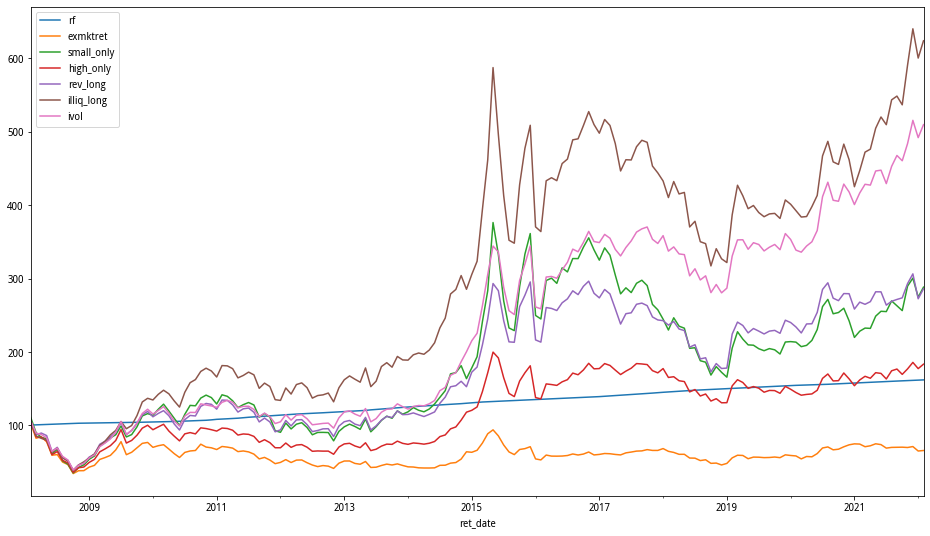

In [199]:
((factors_long_df+1).cumprod()*100).plot()

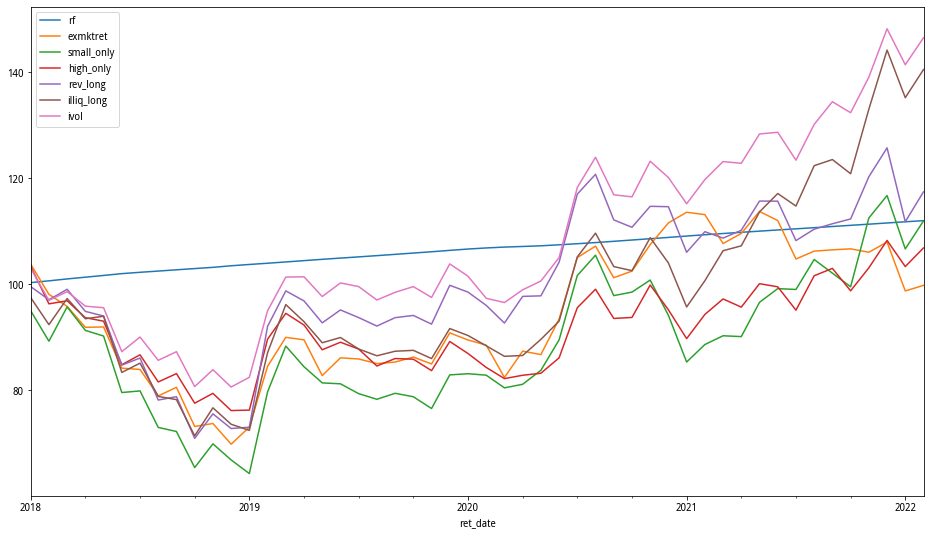

In [200]:
((factors_long_df['2018':]+1).cumprod()*100).plot()

In [201]:
factors_long_df.rename(columns={'ivol':'ivol_long'},inplace=True)

In [202]:
factors_long_df

,rf,exmktret,small_only,high_only,rev_long,illiq_long,ivol_long
ret_date,,,,,,,
2008-02,0.002946,0.024010,0.106350,0.060789,0.059612,0.048717,0.060142
2008-03,0.002746,-0.195480,-0.185605,-0.204875,-0.177674,-0.184564,-0.157342
2008-04,0.002862,0.022519,-0.073984,-0.008138,0.026001,-0.039478,-0.021866
2008-05,0.002953,-0.080798,-0.020726,-0.056888,-0.038600,-0.027371,-0.050738
2008-06,0.003113,-0.236014,-0.258596,-0.240880,-0.249542,-0.207909,-0.222131
2008-07,0.002806,0.014972,0.110389,0.072120,0.084431,0.084488,0.068393
2008-08,0.002681,-0.170063,-0.234635,-0.187086,-0.205410,-0.189043,-0.163784
2008-09,0.002889,-0.067913,-0.088250,-0.068698,-0.063282,-0.080665,-0.086935
...,...,...,...,...,...,...,...


In [203]:
factors_long_df.to_pickle('./data/factors/factors_all_long_only.pkl')